# Import packages

In [1]:
import ee
try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geemap
from geeml.utils import eeprint
import geopandas as gpd
from shapely import wkb
from shapely.geometry import Point
from pyproj import Transformer
import folium
import leafmap.foliumap as leafmap

from sklearn.ensemble import RandomForestClassifier
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score

### Assign spatial folds

In [2]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/postdoc/aliens_sep2018_bioscape2023')
eeprint(pts.limit(5))

In [3]:
class prepareTrainingData:
    """This class prepares training data for the earth engine random forest model."""
    def __init__(self, points: ee.FeatureCollection, targetProperty: str, nFolds: int, proj: str = 'EPSG:4326'):
        """
        Args:
            points (ee.FeatureCollection): ee.FeatureCollection
            targetProperty (str): name of the property that contains the target variable
            nFolds (int): number of folds for cross validation
            proj (str): projection of the data
        """

        self.points = points
        self.targetProperty = targetProperty
        self.nFolds = nFolds
        self.proj = proj

    def addCoordProperty(self, features: ee.FeatureCollection) -> ee.FeatureCollection:
        """
        This function adds coordinates to the points

        Args:
            features (ee.FeatureCollection): ee.FeatureCollection

        Returns:
            ee.FeatureCollection: ee.FeatureCollection
        """
        def coords(feature):
            return feature.geometry().transform(proj = self.proj).coordinates()

        return features.map(lambda ft: ft.set('x', coords(ft).getNumber(0)).set('y', coords(ft).getNumber(1)))
        
    def _preparePoints(self):
        # add coordinates to points.
        points = self.addCoordProperty(self.points)

        # cluster points into groups based on coordinates
        clusterer = ee.Clusterer.wekaKMeans(self.nFolds, seed = 42).train(features = points,inputProperties = ['x','y'])
        points = points.cluster(clusterer)
        return points

In [4]:
wKfold = prepareTrainingData(points=pts, targetProperty='class', nFolds=5)._preparePoints()\
    .select(['change', 'class', 'cluster', 'fid','2023_class'])
eeprint(wKfold.limit(5))

# extract values at points
im_z = ee.Image("projects/ee-gsingh/assets/postdoc/WC_2018_2023_imad").select('Z')
change = im_z.lt(95.811).rename('imad_change')
data = change.sampleRegions(collection=wKfold, properties=['class', 'change', 'cluster', '2023_class'], scale=10, geometries=True)
data.limit(5)

In [5]:
# Create a color palette for unique 'group' values
group_values = data.aggregate_array('cluster').distinct()
palette = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'white']

# Create a dictionary to map each group to a color
group_list = group_values.getInfo()
color_dict = {group: palette[i % len(palette)] for i, group in enumerate(group_list)}

# Create a list of styled FeatureCollections for each group
styled_fc_list = []
for group in group_list:
    color = color_dict[group]
    fc_group = data.filter(ee.Filter.eq('cluster', group))
    styled_fc = fc_group.map(lambda f: f.set('style', {
        'color': color,
        'pointSize': 4,
        'width': 1
    }))
    styled_fc_list.append(styled_fc)

# Combine all styled groups into one
styled_pts = ee.FeatureCollection(styled_fc_list).flatten()

# Set up the map
Map = geemap.Map(center=[-30, 25], zoom=6)
Map.addLayer(styled_pts.style(**{'styleProperty': 'style'}), {}, 'Points by Group')
Map

Map(center=[-30, 25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [5]:
# convert to geopandas dataframe
labelinfo = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
labelinfo.crs = 'EPSG:4326'

# for all points that did not change, set the 2023_class to the 2018 class
labelinfo.loc[labelinfo['change'] == 0, '2023_class'] = labelinfo['class']
print(labelinfo.shape)

labelinfo.head()

(1688, 6)


,geometry,change,class,cluster,imad_change,2023_class
0,POINT (19.07263 -33.80554),0,0,1,0,0.0
1,POINT (19.07793 -33.80796),0,0,1,0,0.0
2,POINT (19.0782 -33.80823),0,0,1,0,0.0
3,POINT (19.14952 -33.73583),0,0,0,0,0.0
4,POINT (19.26657 -33.7528),0,0,0,1,0.0


In [7]:
# run to trust notebook- ensures map displays correctly
!jupyter trust HS_experiments_12082025.ipynb

Signing notebook: HS_experiments_12082025.ipynb


C:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\nbformat\__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [8]:
labelinfo.explore()
labelinfo.shape

(1688, 6)

## Prepare 2018 data

In [9]:
# Read the Feather file
# df18 = pd.read_feather("/home/geethen/invasives/hypinvalimap/data/2018_extracted_data.feather")
df18 = pd.read_feather(r"C:\Users\coach\myfiles\postdoc\Invasives\code\hypinvalimap\data\2018_extracted_data.feather")
# Convert geometry back from WKB
df18['geometry'] = df18['geometry'].apply(wkb.loads)

# Restore as a GeoDataFrame with correct CRS if needed
df18 = gpd.GeoDataFrame(df18, geometry='geometry', crs="EPSG:32734").to_crs("EPSG:4326")
df18

wl,geometry,0.40661,0.41337,0.42013,0.42689,0.43367,0.44044,0.44723,0.45402,0.46082,...,1.77188,1.77812,1.78435,1.95847,1.96467,1.97087,1.97707,1.98326,1.98946,1.99566
0,POINT (19.01091 -33.9917),1.0,1.0,21.0,32.0,53.0,72.0,86.0,87.0,81.0,...,883.0,847.0,806.0,103.0,108.0,112.0,117.0,121.0,126.0,130.0
1,POINT (19.00879 -33.9911),1.0,1.0,1.0,1.0,3.0,4.0,7.0,7.0,4.0,...,232.0,219.0,211.0,43.0,39.0,36.0,33.0,30.0,27.0,25.0
2,POINT (19.00823 -33.99113),1.0,1.0,13.0,36.0,62.0,75.0,78.0,75.0,69.0,...,708.0,672.0,641.0,76.0,81.0,84.0,88.0,93.0,98.0,103.0
3,POINT (19.0014 -33.99701),0.0,0.0,0.0,3.0,6.0,4.0,3.0,2.0,3.0,...,0.0,0.0,0.0,2.0,3.0,4.0,4.0,5.0,5.0,6.0
4,POINT (19.00051 -33.99803),1.0,1.0,1.0,1.0,8.0,14.0,16.0,15.0,8.0,...,1.0,1.0,1.0,4.0,5.0,5.0,6.0,7.0,6.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,POINT (19.49762 -33.99499),147.0,251.0,263.0,320.0,346.0,372.0,379.0,374.0,369.0,...,1923.0,1896.0,1884.0,1293.0,1288.0,1284.0,1281.0,1278.0,1272.0,1267.0
1682,POINT (19.49639 -33.99409),206.0,292.0,337.0,409.0,464.0,510.0,543.0,565.0,569.0,...,2674.0,2670.0,2662.0,2062.0,2053.0,2046.0,2039.0,2031.0,2021.0,2013.0
1683,POINT (19.4938 -33.99384),1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,...,440.0,430.0,423.0,167.0,157.0,148.0,138.0,130.0,119.0,110.0
1684,POINT (19.4932 -33.99476),1.0,1.0,1.0,4.0,8.0,9.0,14.0,15.0,16.0,...,761.0,748.0,738.0,379.0,367.0,353.0,341.0,328.0,313.0,300.0


### Prepare 2023 data

In [6]:
# df23 = gpd.read_file("/home/geethen/invasives/hypinvalimap/data/2023_extracted.geojson")
df23 = gpd.read_file(r"C:\Users\coach\myfiles\postdoc\Invasives\code\hypinvalimap\data\2023_extracted.geojson")
df23 = df23.drop(['class', 'change','group', 'notes', 'index_right', 'fid', 'dist'], axis=1)
df23

,377.19565,382.20566,387.21564,392.22565,397.22565,402.23566,407.24564,412.25565,417.26566,422.27563,...,2460.8057,2465.8157,2470.8157,2475.8257,2480.8357,2485.8457,2490.8557,2495.8657,2500.8757,geometry
0,-0.009968,-0.008733,0.002173,0.005276,0.011025,0.011454,0.017868,0.018317,0.018992,0.019012,...,-0.002678,0.004468,-0.000922,-0.002775,-0.024097,-0.044038,0.068780,0.005774,0.010309,POINT (19.16467 -33.99555)
1,-0.019244,-0.006666,0.004218,0.006731,0.010474,0.014222,0.016361,0.018346,0.020782,0.021844,...,-0.006092,-0.000617,0.001371,0.001319,-0.019521,-0.017924,0.002764,-0.034498,-0.015706,POINT (19.14254 -33.99885)
2,-0.012649,0.010791,0.009590,0.004053,0.009603,0.016292,0.014158,0.017616,0.019166,0.019803,...,-0.005056,-0.000389,0.005122,-0.004704,-0.011844,-0.009114,0.050041,-0.011703,0.033020,POINT (19.15589 -33.98977)
3,-0.027425,-0.001593,0.003823,0.001784,0.007935,0.012748,0.015931,0.019677,0.019615,0.020735,...,0.000092,-0.000566,-0.002532,0.004520,-0.019516,0.008591,0.005424,0.013045,0.033618,POINT (19.13976 -33.99951)
4,0.000811,0.006930,0.012532,0.013503,0.019126,0.019126,0.019888,0.020768,0.023830,0.023573,...,-0.001692,0.007117,-0.004049,-0.011886,-0.005820,-0.022991,0.033635,0.005198,-0.012026,POINT (19.15018 -33.99258)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,0.043676,0.040303,0.046708,0.058847,0.064514,0.063104,0.075086,0.077596,0.080479,0.079501,...,0.053454,0.053556,0.055151,0.054108,0.070669,0.067385,0.124843,0.068315,0.080366,POINT (19.42509 -33.75278)
1684,-0.006192,0.004535,0.006905,0.017799,0.025424,0.024722,0.027945,0.034898,0.035066,0.039167,...,0.014081,0.015742,0.016449,0.019183,0.012901,0.007154,-0.027815,-0.024409,-0.001350,POINT (19.42491 -33.73767)
1685,-0.007330,0.002634,0.013902,0.014275,0.019016,0.024241,0.027193,0.030747,0.030461,0.035623,...,0.012298,0.011941,0.015408,0.008054,0.038101,0.000735,-0.081278,0.086065,0.036685,POINT (19.42439 -33.78279)
1686,0.062697,0.042929,0.059132,0.054877,0.079603,0.075919,0.084128,0.079504,0.088336,0.099900,...,0.060377,0.062541,0.066788,0.054639,0.048645,0.102097,0.166185,0.032145,0.069856,POINT (19.4255 -33.74736)


# Remove problem bands

In [7]:
import pandas as pd
import numpy as np

# Separate wavelength columns from metadata columns
wavelength_cols = [col for col in df23.columns if col.replace('.', '', 1).isdigit()]
non_wavelength_cols = [col for col in df23.columns if col not in wavelength_cols]

# Convert wavelength column names to float for comparison
wavelengths = np.array(wavelength_cols, dtype=float)

# Apply the mask
mask = (
    (wavelengths < 450) |
    ((wavelengths >= 1340) & (wavelengths <= 1480)) |
    ((wavelengths >= 1800) & (wavelengths <= 1980)) |
    (wavelengths > 2000)
)

# Determine which columns to drop based on the mask
wavelengths_to_drop = np.array(wavelength_cols)[mask]

# Drop the unwanted wavelength columns
df23filtered = df23.drop(columns=wavelengths_to_drop)


# Band resampling

In [12]:
# Separate wavelength columns from metadata columns
wavelength23_cols = [col for col in df23filtered.columns if col.replace('.', '', 1).isdigit()]

# Convert wavelength column names to float for comparison
wavelengths23 = np.array(wavelength23_cols, dtype=float)
wavelengths23

# Separate wavelength columns from metadata columns
wavelength18_cols = [col for col in df18.columns if col.replace('.', '', 1).isdigit()]

# Convert wavelength column names to float for comparison
wavelengths18 = np.array(wavelength18_cols, dtype=float)*1000
wavelengths18

array([ 406.61,  413.37,  420.13,  426.89,  433.67,  440.44,  447.23,
        454.02,  460.82,  467.62,  474.42,  481.23,  488.05,  494.87,
        501.7 ,  508.52,  515.36,  522.19,  529.04,  535.89,  542.74,
        549.59,  556.45,  563.31,  570.17,  577.04,  583.91,  590.78,
        597.66,  604.54,  611.42,  618.3 ,  625.19,  632.08,  638.97,
        645.86,  652.76,  659.65,  666.54,  673.44,  680.35,  687.25,
        694.14,  701.04,  707.95,  714.85,  721.76,  728.66,  735.56,
        742.47,  749.37,  756.27,  763.18,  770.08,  776.98,  783.88,
        790.78,  797.68,  804.58,  811.48,  818.37,  825.26,  832.16,
        839.05,  845.94,  852.82,  859.71,  866.59,  873.47,  880.34,
        887.22,  894.09,  900.95,  907.81,  914.68,  921.53,  928.39,
        935.24,  942.09,  948.92,  955.76,  962.6 ,  969.43,  972.71,
        979.05,  985.38,  991.72,  998.05, 1004.39, 1010.72, 1017.05,
       1023.39, 1029.72, 1036.05, 1042.38, 1048.71, 1055.04, 1061.37,
       1067.7 , 1074

In [13]:
# Spectra Resampling

import numpy as np
import pandas as pd
from spectral import BandResampler

# Example placeholders — replace with your real data
# ----------------------------------------------------
# df18: reflectance from older sensor, shape (n_samples, n_bands_18)
# df23: reflectance from AVIRIS-NG, shape (n_samples, n_bands_23)

# Band centers in nanometers (must be in increasing order)
band_centers_18 = wavelengths18  # wavelengths for df18, e.g., [450, 460, ..., 900]
band_centers_ng = wavelengths23  # wavelengths for AVIRIS-NG, e.g., [400.5, 405.5, ..., 2500]

# FWHM for AVIRIS-NG (real or approximate)
fwhm_ng = np.full_like(band_centers_ng, fill_value=5.0, dtype=np.float32)
fwhm_ng


array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [14]:
band_centers_18.shape#202 bands
band_centers_ng.shape#245 bands

(245,)

In [15]:
def estimate_fwhm_from_band_centers(band_centers):
    """
    Estimate FWHM as half the spacing to adjacent bands.
    This is the default fallback method used by SPy when fwhm_src is None.
    """
    diffs = np.diff(band_centers)
    fwhm = np.zeros_like(band_centers)
    fwhm[1:-1] = 0.5 * np.minimum(diffs[:-1], diffs[1:])
    fwhm[0] = fwhm[1]  # use second band's spacing
    fwhm[-1] = fwhm[-2]
    return fwhm


In [16]:
# Estimate source FWHM (optional, SPy will do this internally)
# fwhm_18 = estimate_fwhm_from_band_centers(band_centers_18)

# Create BandResampler: only fwhm_dst is specified
resampler = BandResampler(
    centers1= band_centers_18,
    centers2= band_centers_ng,
    fwhm1=None,            # SPy estimates from band_centers_18
    fwhm2=fwhm_ng          # Real or assumed for AVIRIS-NG
)
# 131 bands wth no overlap

In [17]:
# Convert DataFrame rows to array for processing
reflectance_18 = df18[wavelength18_cols].values  # shape (n_samples, n_bands_18)

# Preallocate output array
resampled_array = np.empty((reflectance_18.shape[0], len(band_centers_ng)))

# Resample each spectrum (row-wise)
for i, spectrum in enumerate(reflectance_18):
    resampled_array[i] = resampler(spectrum)


In [18]:
# Convert back to DataFrame with AVIRIS-NG wavelength labels
df18_resampled_to_ng = pd.DataFrame(
    resampled_array,
    columns=[f"{w}" for w in band_centers_ng]
)


In [19]:
nan_cols = df18_resampled_to_ng.columns[df18_resampled_to_ng.isna().any()]
if len(nan_cols) > 0:
    print("Warning: Some AVIRIS-NG bands had no spectral overlap with df18 and returned NaN:")
    print(nan_cols.tolist())


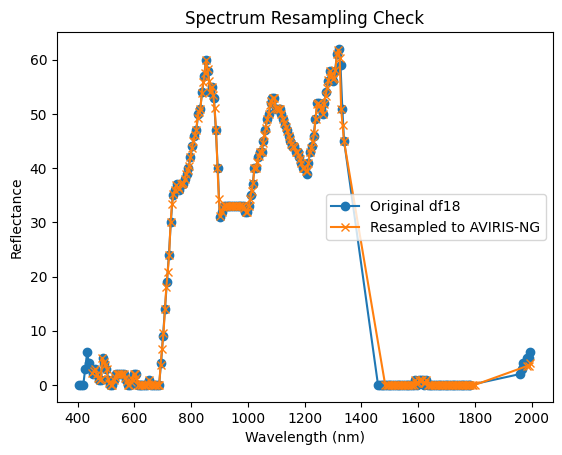

In [20]:
import matplotlib.pyplot as plt

idx = 3  # pick a sample
plt.plot(band_centers_18, reflectance_18[idx], label='Original df18', marker='o')
plt.plot(band_centers_ng, resampled_array[idx], label='Resampled to AVIRIS-NG', marker='x')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Spectrum Resampling Check")
plt.legend()
plt.show()


In [21]:
df18_resampled_to_ng

,452.32565,457.33566,462.34564,467.35565,472.35565,477.36566,482.37564,487.38565,492.39566,497.40564,...,1769.6056,1774.6156,1779.6256,1784.6356,1789.6356,1794.6456,1799.6556,1984.9757,1989.9856,1994.9956
0,86.879069,84.123137,81.090895,82.0,87.665519,90.940339,94.155108,99.0,99.723911,100.866075,...,890.711768,837.196128,824.990719,806.0,806.0,806.0,806.0,112.450247,114.5,116.483814
1,7.000000,5.561568,4.272685,7.0,9.428080,10.000000,10.000000,10.0,10.000000,11.154767,...,234.669458,218.863524,214.705506,211.0,211.0,211.0,211.0,36.230127,35.0,34.008093
2,75.362793,72.123137,69.545369,75.0,80.665519,85.492610,91.124087,95.0,95.723911,96.288692,...,718.084620,667.197646,655.358836,641.0,641.0,641.0,641.0,84.950372,87.0,89.479768
3,2.120931,2.479477,2.909105,2.0,1.190640,1.000000,1.124087,5.0,4.276089,3.711308,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3.499625,3.5,3.995954
4,15.120931,11.643660,8.090895,9.0,9.809360,9.611932,9.000000,9.0,9.000000,8.422616,...,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,5.409127,5.0,5.495954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,374.604655,371.602614,369.454474,374.0,386.140398,395.597153,406.341238,417.0,417.000000,418.443459,...,1932.491407,1898.024943,1889.558259,1884.0,1884.0,1884.0,1884.0,1284.958880,1282.5,1280.020232
1682,562.339518,566.917909,569.363579,573.0,591.615278,603.373288,615.744520,639.0,644.067375,648.886918,...,2672.516968,2667.187936,2665.705506,2662.0,2662.0,2662.0,2662.0,2045.598882,2041.5,2037.532371
1683,2.758138,3.000000,3.000000,3.0,7.046799,10.328407,14.372260,26.0,29.619553,31.000000,...,443.262671,429.471813,426.242318,423.0,423.0,423.0,423.0,147.509133,143.0,138.536418
1684,14.879069,15.479477,16.908949,26.0,34.902959,41.268746,48.310217,58.0,58.723911,60.154767,...,764.855884,746.863220,742.631883,738.0,738.0,738.0,738.0,352.148885,346.0,339.552603


In [22]:
df18resampled = pd.concat([df18[['geometry']], df18_resampled_to_ng], axis=1)
gdf18 = gpd.sjoin_nearest(df18resampled, labelinfo[['geometry', 'class','2023_class', 'cluster', 'change', 'imad_change']], how='inner', distance_col='dist')
gdf18.dropna(subset=['class'],inplace=True)
gdf18 = gdf18[~gdf18.index.duplicated(keep='first')]
gdf18.shape

(1686, 253)

In [8]:
gdf23 = gpd.sjoin_nearest(df23filtered, labelinfo[['geometry', 'class', 'cluster', 'change', '2023_class', 'imad_change']], how='left', distance_col='dist')
gdf23.dropna(subset=['2023_class'], inplace=True)

gdf23['2023_class'] = gdf23['2023_class'].astype(int)
df23.shape
gdf23 = gdf23[gdf23['2023_class']!= 12]
gdf23.shape

(1639, 253)

In [10]:
# Absolute path for clarity
output_path = r"c:\Users\coach\myfiles\postdoc\Invasives\code\hypinvalimap\data\2023_wessels_HSI_evalpts.geojson"

# Export to GeoJSON
gdf23.to_file(output_path, driver='GeoJSON')

print(f"Successfully exported gdf23 to: {output_path}")

Successfully exported gdf23 to: c:\Users\coach\myfiles\postdoc\Invasives\code\hypinvalimap\data\2023_wessels_HSI_evalpts.geojson


In [11]:
import geopandas as gpd

# Path to the file you just saved
check_path = r"c:\Users\coach\myfiles\postdoc\Invasives\code\hypinvalimap\data\2023_wessels_HSI_evalpts.geojson"

# Read it back in
gdf_check = gpd.read_file(check_path)

# Verify results
print(f"File loaded. Shape: {gdf_check.shape}")
print(f"Target column '2023_class' count: {gdf_check['2023_class'].notna().sum()}")
display(gdf_check.head())

File loaded. Shape: (1639, 254)
Target column '2023_class' count: 1639


,452.32565,457.33566,462.34564,467.35565,472.35565,477.36566,482.37564,487.38565,492.39566,497.40564,...,1994.9956,index_right,class,cluster,change,2023_class,imad_change,dist,class_label,geometry
0,0.029255,0.031248,0.030538,0.033080,0.033601,0.033967,0.035573,0.037723,0.038406,0.041088,...,0.000257,667,0,3,1,10,0,0.000038,Water,POINT (19.16467 -33.99555)
1,0.031462,0.031475,0.032512,0.033778,0.035501,0.036427,0.037357,0.038891,0.040861,0.041459,...,-0.001016,668,0,3,1,10,0,0.000023,Water,POINT (19.14254 -33.99885)
2,0.029640,0.029916,0.031831,0.031423,0.033003,0.034365,0.034843,0.037438,0.038142,0.040492,...,0.000788,669,0,3,1,10,0,0.000017,Water,POINT (19.15589 -33.98977)
3,0.029229,0.030666,0.031855,0.032279,0.032856,0.034640,0.035479,0.037213,0.039032,0.041118,...,-0.000022,670,0,3,1,10,0,0.000044,Water,POINT (19.13976 -33.99951)
4,0.031340,0.031953,0.032576,0.033551,0.034952,0.035205,0.036448,0.037733,0.038946,0.039798,...,-0.000452,671,0,3,1,10,0,0.000030,Water,POINT (19.15018 -33.99258)


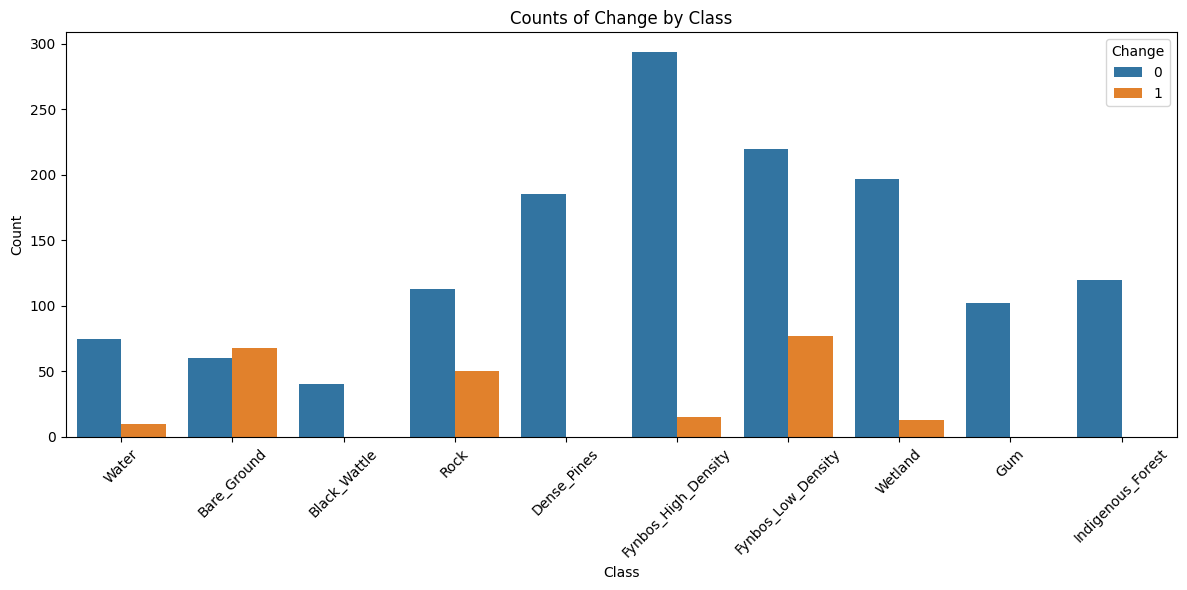

In [9]:
import seaborn as sns

# Map class codes to descriptive names
classDict = {"0": "Bare_Ground", "1": "Black_Wattle", "2": "Dense_Pines", "3": "Fynbos_High_Density", "4": "Fynbos_Low_Density", "5": "Gum", "6": "Indigenous_Forest", "7": "Rock", "8": "Wetland","9": "Snow", "10": "Water"}

gdf23['class_label'] = gdf23['2023_class'].astype(str).map(classDict)

# Now plot with the mapped labels
plt.figure(figsize=(12, 6))
sns.countplot(data=gdf23, x='class_label', hue='change')
plt.title('Counts of Change by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Change')
plt.tight_layout()
plt.show()


### Models

### Experiment 1 (Gold-standard): train independent models for 2018 (all) and 2023(all), predict on respective year

### 2018

In [25]:
# Features and target
X = gdf18[wavelength23_cols]
y = gdf18['class'].astype(int)
groups = gdf18['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.56, F1 Score: 0.58
              precision    recall  f1-score   support

           0       1.00      0.28      0.43        18
           1       0.00      0.00      0.00         0
           2       0.82      0.59      0.69       160
           3       0.28      0.67      0.40        39
           4       0.58      0.53      0.55        49
           5       0.53      0.55      0.54        38
           6       0.31      0.50      0.38        22
           7       0.75      0.43      0.55        14
           8       0.54      0.47      0.50        58
           9       0.00      0.00      0.00         0
          10       0.77      0.85      0.81        20

    accuracy                           0.56       418
   macro avg       0.51      0.44      0.44       418
weighted avg       0.65      0.56      0.58       418


Fold 2 — Accuracy: 0.62, F1 Score: 0.62
              precision    recall  f1-score   support

           0       0.62      0.50      0.56       

In [26]:

# Features and target
X = gdf18[wavelength23_cols]
y = gdf18['class'].astype(int)
groups = gdf18['cluster']  # ensure this column exists

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()
# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Print average F1
print(f"\nAverage F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [22:28<00:00, 84.28s/it]



Fold 1 — F1 Score: 0.79
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.00      0.00      0.00         0
           2       0.93      0.88      0.91       160
           3       0.40      0.67      0.50        39
           4       0.84      0.63      0.72        49
           5       0.94      0.76      0.84        38
           6       0.63      0.55      0.59        22
           7       0.76      0.93      0.84        14
           8       0.73      0.76      0.75        58
          10       0.77      0.85      0.81        20

    accuracy                           0.78       418
   macro avg       0.70      0.67      0.68       418
weighted avg       0.82      0.78      0.79       418



100%|██████████| 16/16 [21:16<00:00, 79.79s/it]



Fold 2 — F1 Score: 0.77
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.00      0.00      0.00         0
           2       0.68      0.86      0.76        50
           3       0.74      0.77      0.76        97
           4       0.74      0.62      0.67        45
           5       0.71      0.94      0.81        18
           6       0.81      0.76      0.78        38
           7       0.71      0.77      0.74        22
           8       0.67      0.50      0.57        58
           9       1.00      0.98      0.99        57
          10       1.00      1.00      1.00        19

    accuracy                           0.77       414
   macro avg       0.73      0.71      0.71       414
weighted avg       0.78      0.77      0.77       414



100%|██████████| 16/16 [21:15<00:00, 79.73s/it]



Fold 3 — F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.00      0.00      0.00         0
           2       0.62      0.60      0.61        25
           3       0.76      0.80      0.78        71
           4       0.74      0.73      0.74        63
           5       0.77      0.86      0.81        28
           6       0.92      0.75      0.82        44
           7       0.78      0.85      0.81        41
           8       0.83      0.79      0.81        57
           9       1.00      0.94      0.97        47
          10       0.00      0.00      0.00         0

    accuracy                           0.79       382
   macro avg       0.64      0.64      0.63       382
weighted avg       0.81      0.79      0.80       382



100%|██████████| 16/16 [23:32<00:00, 88.29s/it]



Fold 4 — F1 Score: 0.71
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       1.00      0.05      0.10        19
           2       0.78      0.97      0.87        30
           3       0.89      0.66      0.76        85
           4       0.69      0.71      0.70        59
           5       0.92      0.86      0.89        14
           6       0.30      1.00      0.47         7
           7       0.54      0.87      0.67        15
           8       0.38      0.62      0.48         8
          10       0.90      1.00      0.95        18

    accuracy                           0.72       272
   macro avg       0.72      0.76      0.67       272
weighted avg       0.79      0.72      0.71       272



100%|██████████| 16/16 [23:54<00:00, 89.66s/it]


Fold 5 — F1 Score: 0.62
              precision    recall  f1-score   support

           0       0.65      0.96      0.77        23
           1       1.00      0.04      0.08        24
           2       0.50      1.00      0.67         3
           3       0.87      0.74      0.80        35
           4       0.59      0.81      0.68        36
           5       0.00      0.00      0.00         3
           6       0.32      0.75      0.44         8
           7       0.60      0.43      0.50        21
           8       0.33      0.31      0.32        16
           9       0.92      1.00      0.96        11
          10       1.00      0.95      0.97        20

    accuracy                           0.66       200
   macro avg       0.62      0.64      0.56       200
weighted avg       0.71      0.66      0.62       200


Average F1 Score over 5 folds: 0.74 (0.07)


### 2023

In [27]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf23[wavelength23_cols]
y = gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.59, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.52      0.69      0.59        16
           1       0.00      0.00      0.00         0
           2       0.46      0.71      0.56        34
           3       0.59      0.66      0.62        88
           4       0.51      0.48      0.49        79
           5       0.70      0.39      0.50        18
           6       0.71      0.68      0.69        37
           7       0.61      0.50      0.55        40
           8       0.64      0.47      0.54        68
          10       0.83      1.00      0.90        19

    accuracy                           0.59       399
   macro avg       0.56      0.56      0.55       399
weighted avg       0.60      0.59      0.58       399


Fold 2 — Accuracy: 0.44, F1 Score: 0.43
              precision    recall  f1-score   support

           0       0.38      0.11      0.17        56
           1       0.00      0.00      0.00       

In [28]:
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf23[wavelength23_cols]
y = gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # ensure this column exists

# Create a base TabPFN classifier
base_clf = TabPFNClassifier(device='cuda')
# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Print average F1
print(f"\nAverage F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — F1 Score: 0.72
              precision    recall  f1-score   support

           0       0.52      0.88      0.65        16
           1       0.00      0.00      0.00         0
           2       0.74      0.85      0.79        34
           3       0.77      0.76      0.77        88
           4       0.62      0.61      0.62        79
           5       0.89      0.89      0.89        18
           6       0.90      0.95      0.92        37
           7       0.73      0.60      0.66        40
           8       0.70      0.54      0.61        68
          10       0.79      1.00      0.88        19

    accuracy                           0.72       399
   macro avg       0.67      0.71      0.68       399
weighted avg       0.73      0.72      0.72       399


Fold 2 — F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.56      0.16      0.25        56
           1       0.00      0.00      0.00         0
           2       0.66     

### Experiment 2.1: train on 2018 (all), predict on 2023 (all)

In [29]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.05, F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        38
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        60
           9       0.00      0.00      0.00        59
          10       0.05      1.00      0.09        19

    accuracy                           0.05       399
   macro avg       0.00      0.10      0.01       399
weighted avg       0.00      0.05      0.00       399


Fold 2 — Accuracy: 0.05, F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           2       0.00      0.00      0.00       

In [30]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [20:54<00:00, 78.41s/it]



Fold 1 — Accuracy: 0.10, F1 Score: 0.02
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        18
           6       0.10      1.00      0.17        38
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        60
           9       0.00      0.00      0.00        59
          10       0.00      0.00      0.00        19

    accuracy                           0.10       399
   macro avg       0.01      0.10      0.02       399
weighted avg       0.01      0.10      0.02       399



100%|██████████| 16/16 [20:33<00:00, 77.11s/it]



Fold 2 — Accuracy: 0.05, F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           2       0.00      0.00      0.00       133
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        49
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        22
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        58
          10       0.05      1.00      0.10        20

    accuracy                           0.05       391
   macro avg       0.01      0.11      0.01       391
weighted avg       0.00      0.05      0.00       391



100%|██████████| 16/16 [21:04<00:00, 79.01s/it]



Fold 3 — Accuracy: 0.12, F1 Score: 0.03
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        67
           4       0.00      0.00      0.00        63
           5       0.00      0.00      0.00        28
           6       0.12      1.00      0.21        46
           7       0.00      0.00      0.00        41
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00        49

    accuracy                           0.12       382
   macro avg       0.01      0.11      0.02       382
weighted avg       0.01      0.12      0.03       382



100%|██████████| 16/16 [22:12<00:00, 83.27s/it]



Fold 4 — Accuracy: 0.03, F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        82
           4       0.00      0.00      0.00        61
           5       0.00      0.00      0.00        14
           6       0.03      1.00      0.05         7
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         8
          10       0.00      0.00      0.00        18

    accuracy                           0.03       269
   macro avg       0.00      0.10      0.01       269
weighted avg       0.00      0.03      0.00       269



100%|██████████| 16/16 [22:34<00:00, 84.68s/it]


Fold 5 — Accuracy: 0.04, F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         3
           6       0.04      1.00      0.08         8
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        20

    accuracy                           0.04       198
   macro avg       0.00      0.09      0.01       198
weighted avg       0.00      0.04      0.00       198


Average Accuracy (only folds using 2023 test data): 0.07 (0.04)
Average F1 Score: 0.01 (0.01)


### Experiment 2.2: with L2 normalization

In [26]:
def l2_normalize_dataframe(df, wavelength_cols):
    # Compute L2 norm per row
    l2_norm = np.sqrt((df[wavelength_cols] ** 2).sum(axis=1))
    
    # Avoid division by zero
    l2_norm = l2_norm.replace(0, np.nan)
    
    # Normalize the wavelength columns
    df[wavelength_cols] = df[wavelength_cols].div(l2_norm, axis=0)
    
    return df

In [32]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.32, F1 Score: 0.29
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           2       0.37      0.43      0.40        37
           3       0.26      0.14      0.18        91
           4       0.27      0.38      0.31        45
           5       0.57      0.22      0.32        18
           6       0.91      0.26      0.41        38
           7       0.29      0.64      0.40        22
           8       0.29      0.68      0.40        60
           9       0.00      0.00      0.00        59
          10       0.89      0.42      0.57        19

    accuracy                           0.32       399
   macro avg       0.44      0.38      0.36       399
weighted avg       0.35      0.32      0.29       399


Fold 2 — Accuracy: 0.47, F1 Score: 0.47
              precision    recall  f1-score   support

           0       0.17      0.07      0.10        15
           2       0.56      0.43      0.49       

In [27]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [20:54<00:00, 78.40s/it]



Fold 1 — Accuracy: 0.33, F1 Score: 0.29
              precision    recall  f1-score   support

           0       0.33      0.80      0.47        10
           2       0.40      0.57      0.47        37
           3       0.60      0.13      0.22        91
           4       0.33      0.13      0.19        45
           5       1.00      0.17      0.29        18
           6       0.75      0.24      0.36        38
           7       0.35      0.64      0.45        22
           8       0.25      0.85      0.39        60
           9       0.06      0.02      0.03        59
          10       0.73      0.42      0.53        19

    accuracy                           0.33       399
   macro avg       0.48      0.40      0.34       399
weighted avg       0.44      0.33      0.29       399



100%|██████████| 16/16 [21:37<00:00, 81.10s/it]



Fold 2 — Accuracy: 0.48, F1 Score: 0.48
              precision    recall  f1-score   support

           0       0.12      0.13      0.12        15
           2       0.70      0.33      0.45       133
           3       0.28      0.39      0.33        38
           4       0.59      0.35      0.44        49
           5       1.00      0.50      0.67        42
           6       0.85      0.77      0.81        22
           7       0.52      1.00      0.68        14
           8       0.40      0.91      0.55        58
           9       0.00      0.00      0.00         0
          10       0.33      0.20      0.25        20

    accuracy                           0.48       391
   macro avg       0.48      0.46      0.43       391
weighted avg       0.59      0.48      0.48       391



100%|██████████| 16/16 [23:02<00:00, 86.44s/it]



Fold 3 — Accuracy: 0.35, F1 Score: 0.26
              precision    recall  f1-score   support

           0       0.23      0.83      0.36         6
           2       0.43      0.65      0.52        23
           3       0.33      0.06      0.10        67
           4       0.63      0.19      0.29        63
           5       1.00      0.14      0.25        28
           6       0.43      0.07      0.11        46
           7       0.50      0.80      0.62        41
           8       0.26      0.95      0.41        59
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00         0

    accuracy                           0.35       382
   macro avg       0.38      0.37      0.27       382
weighted avg       0.41      0.35      0.26       382



100%|██████████| 16/16 [22:50<00:00, 85.63s/it]



Fold 4 — Accuracy: 0.27, F1 Score: 0.27
              precision    recall  f1-score   support

           0       0.35      0.81      0.49        16
           1       0.00      0.00      0.00        19
           2       0.47      0.31      0.38        29
           3       0.33      0.05      0.09        82
           4       0.67      0.16      0.26        61
           5       0.33      0.07      0.12        14
           6       0.38      0.71      0.50         7
           7       0.55      0.73      0.63        15
           8       0.04      0.62      0.07         8
           9       0.00      0.00      0.00         0
          10       1.00      0.78      0.88        18

    accuracy                           0.27       269
   macro avg       0.38      0.39      0.31       269
weighted avg       0.45      0.27      0.27       269



100%|██████████| 16/16 [22:54<00:00, 85.93s/it]


Fold 5 — Accuracy: 0.33, F1 Score: 0.29
              precision    recall  f1-score   support

           0       0.25      0.65      0.37        23
           1       0.00      0.00      0.00        22
           2       0.60      1.00      0.75         3
           3       0.80      0.11      0.20        35
           4       1.00      0.17      0.29        36
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         8
           7       0.75      0.43      0.55        21
           8       0.16      0.81      0.26        16
           9       0.00      0.00      0.00        11
          10       0.60      0.75      0.67        20

    accuracy                           0.33       198
   macro avg       0.38      0.36      0.28       198
weighted avg       0.51      0.33      0.29       198


Average Accuracy (only folds using 2023 test data): 0.35 (0.07)
Average F1 Score: 0.32 (0.08)


### Experiment 3: Wessels 2016 using IRMAD

refer to notebook IRMAD experiments.ipynb

### Experiment 4.1: E2.4+filtering

In [25]:
def l2_normalize_dataframe(df, wavelength_cols):
    # Compute L2 norm per row
    l2_norm = np.sqrt((df[wavelength_cols] ** 2).sum(axis=1))
    
    # Avoid division by zero
    l2_norm = l2_norm.replace(0, np.nan)
    
    # Normalize the wavelength columns
    df[wavelength_cols] = df[wavelength_cols].div(l2_norm, axis=0)
    
    return df

In [26]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['change']==0]], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.65, F1 Score: 0.64
              precision    recall  f1-score   support

           0       0.59      0.50      0.54        20
           1       0.00      0.00      0.00         0
           2       0.50      0.73      0.60        84
           3       0.63      0.68      0.65       180
           4       0.58      0.58      0.58        85
           5       0.65      0.42      0.51        36
           6       0.74      0.72      0.73        75
           7       0.58      0.64      0.61        44
           8       0.56      0.37      0.45       118
           9       1.00      0.96      0.98        57
          10       0.93      1.00      0.96        38

    accuracy                           0.65       737
   macro avg       0.62      0.60      0.60       737
weighted avg       0.65      0.65      0.64       737


Fold 2 — Accuracy: 0.54, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.88      0.28      0.42       

In [27]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['change']==0]], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [52:32<00:00, 197.06s/it]



Fold 1 — Accuracy: 0.77, F1 Score: 0.77
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        20
           1       0.00      0.00      0.00         0
           2       0.71      0.89      0.79        84
           3       0.79      0.78      0.79       180
           4       0.70      0.61      0.65        85
           5       0.75      0.83      0.79        36
           6       0.86      0.89      0.88        75
           7       0.70      0.75      0.73        44
           8       0.69      0.56      0.62       118
           9       0.98      0.98      0.98        57
          10       0.95      1.00      0.97        38

    accuracy                           0.77       737
   macro avg       0.70      0.72      0.71       737
weighted avg       0.77      0.77      0.77       737



100%|██████████| 16/16 [54:26<00:00, 204.18s/it]



Fold 2 — Accuracy: 0.72, F1 Score: 0.73
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        25
           1       0.00      0.00      0.00         0
           2       0.85      0.73      0.78       256
           3       0.37      0.61      0.46        70
           4       0.70      0.70      0.70        81
           5       0.76      0.61      0.68        79
           6       0.67      0.86      0.75        44
           7       0.86      0.89      0.88        28
           8       0.73      0.74      0.74       113
          10       1.00      0.90      0.95        39

    accuracy                           0.72       735
   macro avg       0.69      0.64      0.65       735
weighted avg       0.76      0.72      0.73       735



100%|██████████| 16/16 [1:01:12<00:00, 229.50s/it]



Fold 3 — Accuracy: 0.77, F1 Score: 0.78
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.00      0.00      0.00         0
           2       0.65      0.90      0.75        48
           3       0.65      0.79      0.71       135
           4       0.75      0.68      0.72       120
           5       0.93      0.78      0.85        54
           6       0.92      0.68      0.78        90
           7       0.78      0.87      0.82        82
           8       0.91      0.74      0.82       115
           9       1.00      0.94      0.97        47
          10       0.00      0.00      0.00         0

    accuracy                           0.77       703
   macro avg       0.65      0.62      0.63       703
weighted avg       0.80      0.77      0.78       703



100%|██████████| 16/16 [1:03:48<00:00, 239.25s/it]



Fold 4 — Accuracy: 0.66, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        33
           1       0.29      0.11      0.15        38
           2       0.81      0.85      0.83        59
           3       0.78      0.56      0.65       167
           4       0.70      0.69      0.69       116
           5       0.61      0.71      0.66        28
           6       0.29      0.86      0.43        14
           7       0.76      0.93      0.84        30
           8       0.16      0.44      0.24        16
          10       0.97      0.97      0.97        35

    accuracy                           0.66       536
   macro avg       0.61      0.69      0.63       536
weighted avg       0.70      0.66      0.67       536



100%|██████████| 16/16 [1:07:20<00:00, 252.53s/it]


Fold 5 — Accuracy: 0.62, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        44
           1       0.00      0.00      0.00        45
           2       0.40      1.00      0.57         6
           3       0.84      0.59      0.69        69
           4       0.56      0.87      0.68        70
           5       0.00      0.00      0.00         6
           6       0.32      0.50      0.39        16
           7       0.83      0.45      0.58        42
           8       0.40      0.62      0.49        32
           9       0.92      1.00      0.96        11
          10       0.82      0.93      0.87        40

    accuracy                           0.62       381
   macro avg       0.52      0.61      0.54       381
weighted avg       0.58      0.62      0.58       381


Average Accuracy (only folds using 2023 test data): 0.71 (0.06)
Average F1 Score: 0.70 (0.07)


### Experiment 4.2: E2.4+filtering

In [28]:
def l2_normalize_dataframe(df, wavelength_cols):
    # Compute L2 norm per row
    l2_norm = np.sqrt((df[wavelength_cols] ** 2).sum(axis=1))
    
    # Avoid division by zero
    l2_norm = l2_norm.replace(0, np.nan)
    
    # Normalize the wavelength columns
    df[wavelength_cols] = df[wavelength_cols].div(l2_norm, axis=0)
    
    return df

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['imad_change']==1]], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.62, F1 Score: 0.61
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.00      0.00      0.00         0
           2       0.56      0.78      0.65        76
           3       0.61      0.72      0.66       159
           4       0.48      0.54      0.51        80
           5       0.50      0.18      0.27        22
           6       0.76      0.71      0.73        48
           7       0.50      0.70      0.58        30
           8       0.49      0.34      0.40        89
           9       0.90      0.66      0.76        91
          10       1.00      0.83      0.90        23

    accuracy                           0.62       628
   macro avg       0.62      0.51      0.53       628
weighted avg       0.63      0.62      0.61       628


Fold 2 — Accuracy: 0.54, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.83      0.26      0.40       

In [30]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['imad_change']==1]], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [38:21<00:00, 143.83s/it]



Fold 1 — Accuracy: 0.72, F1 Score: 0.72
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           2       0.66      0.91      0.76        76
           3       0.77      0.81      0.79       159
           4       0.62      0.57      0.60        80
           5       0.73      0.73      0.73        22
           6       0.81      0.81      0.81        48
           7       0.55      0.70      0.62        30
           8       0.59      0.48      0.53        89
           9       0.91      0.76      0.83        91
          10       0.95      0.91      0.93        23

    accuracy                           0.72       628
   macro avg       0.76      0.70      0.71       628
weighted avg       0.73      0.72      0.72       628



100%|██████████| 16/16 [41:39<00:00, 156.20s/it]



Fold 2 — Accuracy: 0.75, F1 Score: 0.76
              precision    recall  f1-score   support

           0       0.86      0.32      0.46        19
           1       0.00      0.00      0.00         0
           2       0.90      0.82      0.86       198
           3       0.46      0.73      0.56        60
           4       0.86      0.73      0.79        78
           5       0.77      0.67      0.72        51
           6       0.56      0.76      0.65        29
           7       0.89      0.77      0.83        22
           8       0.73      0.69      0.71        88
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.98        21

    accuracy                           0.75       566
   macro avg       0.64      0.59      0.60       566
weighted avg       0.79      0.75      0.76       566



100%|██████████| 16/16 [42:03<00:00, 157.72s/it]



Fold 3 — Accuracy: 0.79, F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.00      0.00      0.00         0
           2       0.73      0.85      0.79        39
           3       0.74      0.83      0.78       112
           4       0.71      0.66      0.68        91
           5       0.91      0.89      0.90        35
           6       0.89      0.68      0.77        62
           7       0.77      0.85      0.81        66
           8       0.84      0.78      0.81        68
           9       0.96      0.89      0.93        56
          10       0.00      0.00      0.00         0

    accuracy                           0.79       537
   macro avg       0.64      0.63      0.63       537
weighted avg       0.80      0.79      0.79       537



100%|██████████| 16/16 [45:32<00:00, 170.81s/it]



Fold 4 — Accuracy: 0.66, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.00      0.00      0.00        23
           2       0.90      0.86      0.88        44
           3       0.78      0.61      0.69       152
           4       0.72      0.64      0.68       106
           5       0.79      0.71      0.75        21
           6       0.26      1.00      0.42         9
           7       0.57      0.89      0.69        19
           8       0.12      0.45      0.19        11
           9       0.00      0.00      0.00         0
          10       0.90      1.00      0.95        18

    accuracy                           0.66       421
   macro avg       0.53      0.64      0.55       421
weighted avg       0.70      0.66      0.67       421



100%|██████████| 16/16 [43:16<00:00, 162.28s/it]


Fold 5 — Accuracy: 0.65, F1 Score: 0.62
              precision    recall  f1-score   support

           0       0.63      0.96      0.76        23
           1       0.00      0.00      0.00        25
           2       0.44      1.00      0.62         4
           3       0.90      0.60      0.72        60
           4       0.48      0.85      0.62        48
           5       0.00      0.00      0.00         4
           6       0.35      0.54      0.42        13
           7       0.94      0.45      0.61        38
           8       0.54      0.56      0.55        25
           9       0.76      1.00      0.86        19
          10       0.91      0.94      0.92        31

    accuracy                           0.65       290
   macro avg       0.54      0.63      0.55       290
weighted avg       0.65      0.65      0.62       290


Average Accuracy (only folds using 2023 test data): 0.71 (0.05)
Average F1 Score: 0.71 (0.06)


### Experiment 5.1: SSL

In [31]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['change']==0]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [1]

Fold 1 — Accuracy: 0.59, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.46      0.65      0.54        20
           1       0.00      0.00      0.00         0
           2       0.48      0.62      0.54        84
           3       0.55      0.68      0.61       180
           4       0.52      0.46      0.49        85
           5       0.57      0.36      0.44        36
           6       0.71      0.55      0.62        75
           7       0.66      0.61      0.64        44
           8       0.52      0.36      0.42       118
           9       1.00      0.95      0.97        57
          10       0.74      0.74      0.74        38

    accuracy                           0.59       737
   macro avg       0.56      0.54      0.55       737
weighted avg       0.60      0.59      0.58       737

predicted_class
4    27
3    21
7    11
2     7
8     6
6     3
0     1
Name: count, dtype: int64
1 [3]

Fold 2 — Accuracy: 0.51, F1 Score: 

In [32]:
df23_all_preds['class'] = df23_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], gdf23.loc[gdf23['change']==0][['class', 'cluster']+wavelength23_cols], df23_all_preds[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


Fold 1 — Accuracy: 0.61, F1 Score: 0.61
              precision    recall  f1-score   support

           0       0.56      0.71      0.62        21
           1       0.00      0.00      0.00         0
           2       0.52      0.60      0.56        91
           3       0.58      0.64      0.61       201
           4       0.53      0.63      0.57       112
           5       0.52      0.42      0.46        36
           6       0.72      0.60      0.66        78
           7       0.69      0.60      0.64        55
           8       0.59      0.39      0.47       124
           9       1.00      0.95      0.97        57
          10       0.74      0.76      0.75        38

    accuracy                           0.61       813
   macro avg       0.59      0.57      0.57       813
weighted avg       0.62      0.61      0.61       813


Fold 2 — Accuracy: 0.56, F1 Score: 0.57
              precision    recall  f1-score   support

           0       0.50      0.23      0.32       

TABPFN

In [25]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['change']==0]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [1]


100%|██████████| 16/16 [52:33<00:00, 197.06s/it]



Fold 1 — Accuracy: 0.75, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.00      0.00      0.00         0
           2       0.67      0.88      0.76        84
           3       0.70      0.77      0.74       180
           4       0.74      0.56      0.64        85
           5       0.80      0.92      0.86        36
           6       0.85      0.84      0.85        75
           7       0.69      0.75      0.72        44
           8       0.72      0.47      0.57       118
           9       1.00      0.98      0.99        57
          10       0.90      1.00      0.95        38

    accuracy                           0.75       737
   macro avg       0.72      0.72      0.71       737
weighted avg       0.76      0.75      0.75       737



100%|██████████| 16/16 [46:30<00:00, 174.41s/it]


predicted_class
4     24
3     20
7     16
8      7
2      5
6      2
0      1
10     1
Name: count, dtype: int64
1 [3]


100%|██████████| 16/16 [53:31<00:00, 200.70s/it]



Fold 2 — Accuracy: 0.72, F1 Score: 0.74
              precision    recall  f1-score   support

           0       0.91      0.40      0.56        25
           1       0.00      0.00      0.00         0
           2       0.90      0.73      0.81       256
           3       0.33      0.67      0.45        70
           4       0.70      0.62      0.66        81
           5       0.91      0.77      0.84        79
           6       0.68      0.77      0.72        44
           7       0.86      0.86      0.86        28
           8       0.73      0.74      0.74       113
           9       0.00      0.00      0.00         0
          10       0.95      0.90      0.92        39

    accuracy                           0.72       735
   macro avg       0.63      0.59      0.59       735
weighted avg       0.79      0.72      0.74       735



100%|██████████| 16/16 [44:22<00:00, 166.41s/it]


predicted_class
4     27
3     17
2     11
10     9
7      4
8      3
0      2
6      1
Name: count, dtype: int64
2 [0]


100%|██████████| 16/16 [53:53<00:00, 202.12s/it]



Fold 3 — Accuracy: 0.78, F1 Score: 0.78
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.00      0.00      0.00         0
           2       0.68      0.79      0.73        48
           3       0.72      0.80      0.76       135
           4       0.71      0.68      0.70       120
           5       0.89      0.87      0.88        54
           6       0.92      0.77      0.84        90
           7       0.77      0.83      0.80        82
           8       0.82      0.71      0.76       115
           9       1.00      0.94      0.97        47
          10       0.00      0.00      0.00         0

    accuracy                           0.78       703
   macro avg       0.65      0.63      0.64       703
weighted avg       0.79      0.78      0.78       703



100%|██████████| 16/16 [43:32<00:00, 163.27s/it]


predicted_class
4    27
7    20
3     5
8     5
2     3
0     1
Name: count, dtype: int64
3 [4]


100%|██████████| 16/16 [57:48<00:00, 216.79s/it]



Fold 4 — Accuracy: 0.67, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.31      0.11      0.16        38
           2       0.62      0.95      0.75        59
           3       0.84      0.56      0.67       167
           4       0.62      0.68      0.65       116
           5       0.67      0.71      0.69        28
           6       0.32      0.79      0.46        14
           7       0.71      0.90      0.79        30
           8       0.33      0.56      0.42        16
          10       0.94      0.97      0.96        35

    accuracy                           0.67       536
   macro avg       0.62      0.70      0.63       536
weighted avg       0.69      0.67      0.66       536



100%|██████████| 16/16 [53:07<00:00, 199.22s/it]


predicted_class
4     4
10    1
Name: count, dtype: int64
4 [2]


100%|██████████| 16/16 [1:08:18<00:00, 256.13s/it]



Fold 5 — Accuracy: 0.59, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.67      0.70      0.69        44
           1       1.00      0.07      0.12        45
           2       0.38      1.00      0.55         6
           3       0.69      0.54      0.60        69
           4       0.49      0.80      0.61        70
           5       0.00      0.00      0.00         6
           6       0.33      0.50      0.40        16
           7       0.75      0.43      0.55        42
           8       0.42      0.53      0.47        32
           9       1.00      1.00      1.00        11
          10       0.79      0.93      0.85        40

    accuracy                           0.59       381
   macro avg       0.59      0.59      0.53       381
weighted avg       0.66      0.59      0.56       381



100%|██████████| 16/16 [1:02:21<00:00, 233.85s/it]

predicted_class
4     12
10     2
8      2
3      1
Name: count, dtype: int64

Average Accuracy (only folds using 2023 test data): 0.70 (0.07)
Average F1 Score: 0.70 (0.08)


In [26]:
df23_all_preds['class'] = df23_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], gdf23.loc[gdf23['change']==0][['class', 'cluster']+wavelength23_cols], df23_all_preds[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [1:16:13<00:00, 285.85s/it]



Fold 1 — Accuracy: 0.75, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.00      0.00      0.00         0
           2       0.67      0.84      0.75        89
           3       0.78      0.71      0.74       200
           4       0.61      0.71      0.65       109
           5       0.79      0.92      0.85        36
           6       0.88      0.84      0.86        77
           7       0.75      0.73      0.74        60
           8       0.72      0.54      0.61       125
           9       1.00      0.98      0.99        57
          10       0.91      1.00      0.95        39

    accuracy                           0.75       813
   macro avg       0.72      0.73      0.72       813
weighted avg       0.76      0.75      0.75       813



100%|██████████| 16/16 [1:16:23<00:00, 286.50s/it]



Fold 2 — Accuracy: 0.72, F1 Score: 0.74
              precision    recall  f1-score   support

           0       0.92      0.44      0.60        27
           1       0.00      0.00      0.00         0
           2       0.89      0.70      0.79       267
           3       0.39      0.71      0.50        87
           4       0.70      0.68      0.69       108
           5       0.86      0.71      0.78        79
           6       0.73      0.82      0.77        45
           7       0.84      0.81      0.83        32
           8       0.73      0.74      0.74       116
           9       0.00      0.00      0.00         0
          10       0.98      0.94      0.96        48

    accuracy                           0.72       809
   macro avg       0.64      0.60      0.60       809
weighted avg       0.78      0.72      0.74       809



100%|██████████| 16/16 [1:17:30<00:00, 290.65s/it]



Fold 3 — Accuracy: 0.77, F1 Score: 0.77
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.00      0.00      0.00         0
           2       0.71      0.73      0.72        51
           3       0.69      0.81      0.74       140
           4       0.73      0.69      0.71       147
           5       0.86      0.89      0.87        54
           6       0.91      0.68      0.78        90
           7       0.79      0.83      0.81       102
           8       0.80      0.73      0.77       120
           9       1.00      0.94      0.97        47
          10       0.00      0.00      0.00         0

    accuracy                           0.77       764
   macro avg       0.65      0.63      0.64       764
weighted avg       0.79      0.77      0.77       764



100%|██████████| 16/16 [1:22:38<00:00, 309.93s/it]



Fold 4 — Accuracy: 0.68, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        33
           1       0.31      0.11      0.16        38
           2       0.79      0.93      0.85        59
           3       0.82      0.59      0.69       167
           4       0.66      0.70      0.68       120
           5       0.70      0.75      0.72        28
           6       0.34      0.79      0.48        14
           7       0.69      0.83      0.76        30
           8       0.21      0.56      0.31        16
          10       0.97      0.97      0.97        36

    accuracy                           0.68       541
   macro avg       0.63      0.70      0.64       541
weighted avg       0.71      0.68      0.68       541



100%|██████████| 16/16 [1:25:13<00:00, 319.58s/it]


Fold 5 — Accuracy: 0.62, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        44
           1       1.00      0.07      0.12        45
           2       0.43      1.00      0.60         6
           3       0.71      0.57      0.63        70
           4       0.57      0.83      0.67        82
           5       0.00      0.00      0.00         6
           6       0.33      0.50      0.40        16
           7       0.71      0.48      0.57        42
           8       0.40      0.53      0.46        34
           9       1.00      1.00      1.00        11
          10       0.80      0.93      0.86        42

    accuracy                           0.62       398
   macro avg       0.60      0.60      0.55       398
weighted avg       0.67      0.62      0.58       398


Average Accuracy: 0.71 (0.05)
Average F1 Score: 0.71 (0.07)


### Experiment 5.2: SSL+Imad filtering

In [28]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['imad_change']==1]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['imad_change'] == 0) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [1]

Fold 1 — Accuracy: 0.57, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.00      0.00      0.00         0
           2       0.49      0.58      0.53        76
           3       0.52      0.75      0.61       159
           4       0.45      0.42      0.44        80
           5       0.58      0.50      0.54        22
           6       0.73      0.46      0.56        48
           7       0.59      0.57      0.58        30
           8       0.52      0.34      0.41        89
           9       0.97      0.63      0.76        91
          10       0.81      0.96      0.88        23

    accuracy                           0.57       628
   macro avg       0.58      0.52      0.54       628
weighted avg       0.61      0.57      0.58       628

predicted_class
3     38
4     33
10    25
8     24
6     19
7     16
2     14
5     10
9      4
1      1
0      1
Name: count, dtype: int64

In [29]:
df23_all_preds['class'] = df23_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], gdf23.loc[gdf23['imad_change']==1][['class', 'cluster']+wavelength23_cols], df23_all_preds[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [30]:
# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


Fold 1 — Accuracy: 0.65, F1 Score: 0.65
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.14      1.00      0.25         1
           2       0.57      0.64      0.61        90
           3       0.58      0.79      0.67       197
           4       0.64      0.59      0.62       113
           5       0.77      0.53      0.63        32
           6       0.60      0.61      0.61        67
           7       0.69      0.67      0.68        46
           8       0.60      0.43      0.51       113
           9       0.92      0.76      0.83        95
          10       0.94      0.60      0.73        48

    accuracy                           0.65       813
   macro avg       0.64      0.64      0.60       813
weighted avg       0.67      0.65      0.65       813


Fold 2 — Accuracy: 0.64, F1 Score: 0.64
              precision    recall  f1-score   support

           0       0.83      0.25      0.38       

TABPFN

In [31]:
# with spatial CV

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['imad_change']==1]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['imad_change'] == 0) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [1]


100%|██████████| 16/16 [36:42<00:00, 137.64s/it]



Fold 1 — Accuracy: 0.68, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.00      0.00      0.00         0
           2       0.64      0.88      0.74        76
           3       0.67      0.79      0.72       159
           4       0.56      0.56      0.56        80
           5       0.71      0.77      0.74        22
           6       0.78      0.67      0.72        48
           7       0.56      0.63      0.59        30
           8       0.60      0.40      0.48        89
           9       0.97      0.69      0.81        91
          10       1.00      0.83      0.90        23

    accuracy                           0.68       628
   macro avg       0.67      0.62      0.63       628
weighted avg       0.70      0.68      0.68       628



100%|██████████| 16/16 [32:53<00:00, 123.35s/it]


predicted_class
3     56
4     26
2     21
8     20
6     20
7     14
10    10
5      8
9      7
1      3
Name: count, dtype: int64
1 [3]


100%|██████████| 16/16 [44:46<00:00, 167.91s/it]



Fold 2 — Accuracy: 0.72, F1 Score: 0.74
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        19
           1       0.00      0.00      0.00         0
           2       0.93      0.78      0.85       198
           3       0.39      0.75      0.52        60
           4       0.81      0.64      0.71        78
           5       0.86      0.75      0.80        51
           6       0.57      0.69      0.62        29
           7       0.90      0.82      0.86        22
           8       0.67      0.60      0.63        88
           9       0.00      0.00      0.00         0
          10       0.95      0.95      0.95        21

    accuracy                           0.72       566
   macro avg       0.64      0.59      0.60       566
weighted avg       0.79      0.72      0.74       566



100%|██████████| 16/16 [39:54<00:00, 149.64s/it]


predicted_class
3     81
4     55
5     22
10    20
8     20
2     20
6     15
9      6
7      4
Name: count, dtype: int64
2 [0]


100%|██████████| 16/16 [47:31<00:00, 178.23s/it]



Fold 3 — Accuracy: 0.76, F1 Score: 0.76
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.00      0.00      0.00         0
           2       0.71      0.62      0.66        39
           3       0.72      0.82      0.77       112
           4       0.69      0.67      0.68        91
           5       0.80      0.91      0.85        35
           6       0.89      0.66      0.76        62
           7       0.75      0.80      0.77        66
           8       0.74      0.75      0.74        68
           9       0.98      0.86      0.91        56
          10       0.00      0.00      0.00         0

    accuracy                           0.76       537
   macro avg       0.62      0.60      0.61       537
weighted avg       0.77      0.76      0.76       537



100%|██████████| 16/16 [41:01<00:00, 153.86s/it]


predicted_class
4    49
3    47
8    40
7    24
9    21
6    16
5    15
2    10
1     5
Name: count, dtype: int64
3 [4]


100%|██████████| 16/16 [41:33<00:00, 155.87s/it]



Fold 4 — Accuracy: 0.68, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.00      0.00      0.00        23
           2       0.78      0.91      0.84        44
           3       0.79      0.66      0.72       152
           4       0.64      0.65      0.64       106
           5       0.71      0.71      0.71        21
           6       0.32      1.00      0.49         9
           7       0.57      0.84      0.68        19
           8       0.26      0.55      0.35        11
          10       0.95      1.00      0.97        18

    accuracy                           0.68       421
   macro avg       0.59      0.71      0.62       421
weighted avg       0.68      0.68      0.67       421



100%|██████████| 16/16 [35:28<00:00, 133.01s/it]


predicted_class
4     30
10    22
3     20
6     11
2     10
7      9
8      8
5      5
9      3
0      1
1      1
Name: count, dtype: int64
4 [2]


100%|██████████| 16/16 [42:17<00:00, 158.59s/it]



Fold 5 — Accuracy: 0.59, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.63      0.96      0.76        23
           1       1.00      0.04      0.08        25
           2       0.40      1.00      0.57         4
           3       0.63      0.60      0.62        60
           4       0.46      0.81      0.59        48
           5       0.00      0.00      0.00         4
           6       0.32      0.54      0.40        13
           7       0.75      0.39      0.52        38
           8       0.48      0.40      0.43        25
           9       0.95      0.95      0.95        19
          10       0.95      0.61      0.75        31

    accuracy                           0.59       290
   macro avg       0.60      0.57      0.51       290
weighted avg       0.67      0.59      0.56       290



100%|██████████| 16/16 [38:16<00:00, 143.54s/it]

predicted_class
3     48
4     34
8     10
9      5
2      5
6      3
10     2
5      1
Name: count, dtype: int64

Average Accuracy (only folds using 2023 test data): 0.69 (0.06)
Average F1 Score: 0.68 (0.07)


In [32]:
df23_all_preds['class'] = df23_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], gdf23.loc[gdf23['imad_change']==1][['class', 'cluster']+wavelength23_cols], df23_all_preds[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [1:13:38<00:00, 276.15s/it]



Fold 1 — Accuracy: 0.73, F1 Score: 0.72
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.20      0.33      0.25         3
           2       0.69      0.75      0.72        97
           3       0.74      0.75      0.75       215
           4       0.67      0.67      0.67       106
           5       0.70      0.93      0.80        30
           6       0.73      0.76      0.75        68
           7       0.70      0.64      0.67        44
           8       0.72      0.50      0.59       109
           9       0.86      0.87      0.86        98
          10       0.67      0.91      0.77        33

    accuracy                           0.73       813
   macro avg       0.69      0.71      0.69       813
weighted avg       0.73      0.73      0.72       813



100%|██████████| 16/16 [1:14:56<00:00, 281.01s/it]



Fold 2 — Accuracy: 0.77, F1 Score: 0.77
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        19
           1       0.00      0.00      0.00         0
           2       0.88      0.79      0.83       218
           3       0.59      0.76      0.66       141
           4       0.88      0.80      0.83       133
           5       0.82      0.84      0.83        73
           6       0.67      0.73      0.70        44
           7       0.85      0.85      0.85        26
           8       0.74      0.72      0.73       108
           9       0.27      0.50      0.35         6
          10       0.91      0.73      0.81        41

    accuracy                           0.77       809
   macro avg       0.69      0.65      0.66       809
weighted avg       0.79      0.77      0.77       809



100%|██████████| 16/16 [1:21:02<00:00, 303.91s/it]



Fold 3 — Accuracy: 0.76, F1 Score: 0.76
              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.38      0.60      0.46         5
           2       0.71      0.59      0.64        49
           3       0.68      0.85      0.75       159
           4       0.75      0.71      0.73       140
           5       0.83      0.86      0.84        50
           6       0.83      0.71      0.76        78
           7       0.76      0.78      0.77        90
           8       0.82      0.73      0.77       108
           9       0.96      0.84      0.90        77

    accuracy                           0.76       764
   macro avg       0.72      0.72      0.71       764
weighted avg       0.77      0.76      0.76       764



100%|██████████| 16/16 [1:25:11<00:00, 319.44s/it]



Fold 4 — Accuracy: 0.72, F1 Score: 0.72
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.67      0.25      0.36        24
           2       0.83      0.83      0.83        54
           3       0.74      0.78      0.76       172
           4       0.69      0.71      0.70       136
           5       0.83      0.73      0.78        26
           6       0.47      0.70      0.56        20
           7       0.62      0.71      0.67        28
           8       0.40      0.42      0.41        19
           9       1.00      0.67      0.80         3
          10       0.97      0.82      0.89        40

    accuracy                           0.72       541
   macro avg       0.74      0.67      0.69       541
weighted avg       0.73      0.72      0.72       541



100%|██████████| 16/16 [1:27:25<00:00, 327.87s/it]


Fold 5 — Accuracy: 0.65, F1 Score: 0.63
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        23
           1       0.67      0.08      0.14        25
           2       0.55      0.67      0.60         9
           3       0.82      0.54      0.65       108
           4       0.61      0.84      0.71        82
           5       0.00      0.00      0.00         5
           6       0.33      0.50      0.40        16
           7       0.75      0.47      0.58        38
           8       0.50      0.63      0.56        35
           9       1.00      0.88      0.93        24
          10       0.63      0.94      0.76        33

    accuracy                           0.65       398
   macro avg       0.59      0.59      0.56       398
weighted avg       0.68      0.65      0.63       398


Average Accuracy: 0.73 (0.04)
Average F1 Score: 0.72 (0.05)


## Hybrid

In [34]:
# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


Fold 1 — Accuracy: 0.59, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.14      0.33      0.20         3
           2       0.54      0.58      0.56        97
           3       0.56      0.72      0.63       215
           4       0.50      0.55      0.52       106
           5       0.68      0.43      0.53        30
           6       0.68      0.63      0.66        68
           7       0.68      0.57      0.62        44
           8       0.47      0.33      0.39       109
           9       0.87      0.66      0.75        98
          10       0.67      0.73      0.70        33

    accuracy                           0.59       813
   macro avg       0.59      0.55      0.56       813
weighted avg       0.60      0.59      0.59       813


Fold 2 — Accuracy: 0.59, F1 Score: 0.59
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       

### Experiment 1.5: train on 2018 (no change), predict on 2018 (no change)

### Experiment 1.5: train on 2018 (no change), predict on 2018 (no change)

In [14]:
df18subset = gdf18[gdf18['change'] == 0].copy()

In [15]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = df18subset[wavelength23_cols]
y = df18subset['class'].astype(int)
groups = df18subset['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.41, F1 Score: 0.41
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        12
           1       0.00      0.00      0.00         0
           2       0.09      0.27      0.14        15
           3       0.32      0.69      0.44        64
           4       0.49      0.53      0.51        58
           5       0.80      0.35      0.49        34
           6       0.76      0.25      0.38        51
           7       0.71      0.41      0.52        37
           8       0.59      0.21      0.31        90
          10       0.35      1.00      0.52         8

    accuracy                           0.41       369
   macro avg       0.48      0.40      0.37       369
weighted avg       0.56      0.41      0.41       369


Fold 2 — Accuracy: 0.55, F1 Score: 0.54
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.67      0.11      0.18       

In [37]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df18subset[wavelength23_cols], df18subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .65

Accuracy: 0.63


In [17]:
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf18[wavelength23_cols]
y = gdf18['class'].astype(int)
groups = gdf18['cluster']  # replace with the appropriate grouping column

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


  0%|          | 0/16 [00:00<?, ?it/s]

(…)fn-v2-classifier-finetuned-zk73skhh.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

100%|██████████| 16/16 [01:18<00:00,  4.89s/it]



Fold 1 — Accuracy: 0.62, F1 Score: 0.63
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.00      0.00      0.00         0
           2       0.40      0.56      0.47        32
           3       0.53      0.71      0.61        78
           4       0.65      0.71      0.68        65
           5       0.76      0.42      0.54        38
           6       0.83      0.73      0.78        52
           7       0.91      0.54      0.68        37
           8       0.66      0.44      0.53        91
           9       0.64      0.92      0.75        25
          10       0.53      1.00      0.70         8

    accuracy                           0.62       438
   macro avg       0.62      0.62      0.59       438
weighted avg       0.67      0.62      0.63       438



100%|██████████| 16/16 [01:15<00:00,  4.70s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.68
              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.00      0.00      0.00         0
           2       0.84      0.81      0.82       124
           3       0.32      0.36      0.34        39
           4       0.90      0.57      0.70        49
           5       0.58      0.63      0.60        46
           6       0.58      0.68      0.62        22
           7       0.64      0.82      0.72        11
           8       0.44      0.52      0.48        50
           9       0.00      0.00      0.00         0
          10       1.00      0.90      0.95        20

    accuracy                           0.66       376
   macro avg       0.57      0.55      0.55       376
weighted avg       0.70      0.66      0.68       376



100%|██████████| 16/16 [01:19<00:00,  4.97s/it]



Fold 3 — Accuracy: 0.66, F1 Score: 0.65
              precision    recall  f1-score   support

           0       0.69      0.87      0.77        23
           1       0.50      0.05      0.10        19
           2       0.60      0.75      0.67        16
           3       0.84      0.73      0.78       102
           4       0.63      0.66      0.65        65
           5       0.42      0.36      0.38        14
           6       0.21      0.29      0.24        14
           7       0.53      0.79      0.63        24
           8       0.42      0.56      0.48         9
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.98        21

    accuracy                           0.66       307
   macro avg       0.53      0.55      0.52       307
weighted avg       0.68      0.66      0.65       307



100%|██████████| 16/16 [01:19<00:00,  4.95s/it]



Fold 4 — Accuracy: 0.77, F1 Score: 0.78
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.00      0.00      0.00         0
           2       0.88      0.80      0.83        79
           3       0.81      0.74      0.77        65
           4       0.71      0.74      0.72        39
           5       0.00      0.00      0.00         2
           6       0.70      0.73      0.72        26
           7       0.46      0.55      0.50        11
           8       0.52      0.74      0.61        19
           9       0.86      0.86      0.86        42
          10       0.92      1.00      0.96        12

    accuracy                           0.77       304
   macro avg       0.62      0.63      0.62       304
weighted avg       0.79      0.77      0.78       304



100%|██████████| 16/16 [01:23<00:00,  5.19s/it]


Fold 5 — Accuracy: 0.68, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        15
           1       0.80      0.17      0.28        24
           2       0.75      0.53      0.62        17
           3       0.81      0.91      0.86        43
           4       0.54      0.74      0.62        34
           5       0.00      0.00      0.00         3
           6       0.12      0.40      0.18         5
           7       0.62      0.70      0.66        30
           8       0.71      0.61      0.65        28
           9       0.91      0.67      0.77        48
          10       1.00      1.00      1.00        16

    accuracy                           0.68       263
   macro avg       0.64      0.60      0.59       263
weighted avg       0.75      0.68      0.69       263


Average Accuracy over 5 folds: 0.68 (0.05)
Average F1 Score over 5 folds: 0.68 (0.05)


In [39]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df18subset[wavelength23_cols], df18subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [40]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .785

Accuracy 0.7417503586800573


### Experiment 1.6: train on 2023 (all), predict on 2023 (all)

In [19]:
# use 2018 class for 2023 whereever there is no change
gdf23.loc[gdf23['change'] == 0, '2023_class'] = gdf23['class']
gdf23.dropna(subset=['2023_class'], inplace=True)

In [21]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.42      0.64      0.51        25
           1       0.00      0.00      0.00         0
           2       0.10      0.33      0.15        15
           3       0.48      0.61      0.53        64
           4       0.59      0.64      0.61        84
           5       0.76      0.38      0.51        34
           6       0.78      0.35      0.49        51
           7       0.62      0.74      0.67        46
           8       0.57      0.33      0.42        91
          10       0.36      1.00      0.53         8
          12       0.00      0.00      0.00        18

    accuracy                           0.50       436
   macro avg       0.43      0.46      0.40       436
weighted avg       0.55      0.50      0.50       436


Fold 2 — Accuracy: 0.44, F1 Score: 0.44
              precision    recall  f1-score   support

           0       0.50      0.25      0.33       

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .54

Accuracy: 0.59


In [22]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # replace with the appropriate grouping column

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [01:12<00:00,  4.53s/it]



Fold 1 — Accuracy: 0.58, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.38      0.44      0.41        25
           1       0.00      0.00      0.00         0
           2       0.24      0.53      0.33        15
           3       0.54      0.69      0.60        64
           4       0.60      0.65      0.62        84
           5       0.90      0.56      0.69        34
           6       0.88      0.69      0.77        51
           7       0.64      0.78      0.71        46
           8       0.64      0.41      0.50        91
          10       0.40      1.00      0.57         8
          12       0.00      0.00      0.00        18

    accuracy                           0.58       436
   macro avg       0.47      0.52      0.47       436
weighted avg       0.61      0.58      0.58       436



100%|██████████| 16/16 [01:17<00:00,  4.84s/it]



Fold 2 — Accuracy: 0.53, F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.48      0.19      0.27        52
           1       0.00      0.00      0.00         0
           2       0.66      0.57      0.61        68
           3       0.26      0.52      0.34        31
           4       0.30      0.66      0.41        32
           5       0.65      0.67      0.66        45
           6       0.77      0.91      0.83        22
           7       0.79      0.41      0.54        27
           8       0.64      0.57      0.61        47
          10       0.96      0.89      0.92        27
          12       0.00      0.00      0.00        25

    accuracy                           0.53       376
   macro avg       0.50      0.49      0.47       376
weighted avg       0.56      0.53      0.52       376



100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



Fold 3 — Accuracy: 0.59, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.33      0.80      0.47        25
           1       0.00      0.00      0.00        19
           2       0.43      0.75      0.55        16
           3       0.89      0.52      0.66       103
           4       0.66      0.55      0.60        60
           5       0.41      0.64      0.50        14
           6       0.60      0.64      0.62        14
           7       0.71      0.83      0.77        24
           8       0.50      0.56      0.53         9
          10       0.91      1.00      0.95        20
          12       0.00      0.00      0.00         3

    accuracy                           0.59       307
   macro avg       0.49      0.57      0.51       307
weighted avg       0.65      0.59      0.59       307



100%|██████████| 16/16 [01:22<00:00,  5.16s/it]



Fold 4 — Accuracy: 0.66, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.00      0.00      0.00         0
           2       0.95      0.55      0.70        69
           3       0.74      0.77      0.76        66
           4       0.64      0.77      0.70        57
           5       0.11      0.50      0.18         2
           6       0.62      0.69      0.65        26
           7       0.75      0.50      0.60        24
           8       0.43      0.67      0.52        27
          10       0.92      1.00      0.96        12
          12       0.17      0.09      0.12        11

    accuracy                           0.66       304
   macro avg       0.54      0.56      0.53       304
weighted avg       0.71      0.66      0.67       304



100%|██████████| 16/16 [01:26<00:00,  5.43s/it]


Fold 5 — Accuracy: 0.54, F1 Score: 0.55
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.00      0.00      0.00        21
           2       0.50      0.35      0.41        17
           3       0.71      0.27      0.39        44
           4       0.82      0.68      0.74        59
           5       0.03      0.33      0.05         3
           6       0.05      0.20      0.08         5
           7       0.64      0.83      0.72        42
           8       0.53      0.66      0.58        32
          10       0.90      1.00      0.95        18
          12       0.00      0.00      0.00         6

    accuracy                           0.54       263
   macro avg       0.44      0.44      0.41       263
weighted avg       0.60      0.54      0.55       263


Average Accuracy over 5 folds: 0.58 (0.05)
Average F1 Score over 5 folds: 0.58 (0.05)


In [45]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [46]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .690

100%|██████████| 16/16 [00:04<00:00,  3.91it/s]

Accuracy 0.6761565836298933


### Experiment 2: train on 2023 (no change), predict on 2023 (no change)

In [ ]:
df23subset = gdf23[gdf23['change'] == 0].copy()
# class and 2023_class are the same for no change points

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
groups = df23subset['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.56, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.00      0.00      0.00         0
           2       0.10      0.33      0.16        15
           3       0.49      0.56      0.52        64
           4       0.60      0.79      0.68        58
           5       0.83      0.44      0.58        34
           6       0.83      0.39      0.53        51
           7       0.91      0.78      0.84        37
           8       0.66      0.43      0.52        90
          10       0.38      1.00      0.55         8

    accuracy                           0.56       369
   macro avg       0.55      0.54      0.51       369
weighted avg       0.66      0.56      0.58       369


Fold 2 — Accuracy: 0.57, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        23
           1       0.11      0.05      0.07       

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .60

Accuracy: 0.63


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
groups = df23subset['cluster']  # replace with the appropriate grouping column

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.60, F1 Score: 0.61
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.00      0.00      0.00         0
           2       0.21      0.60      0.32        15
           3       0.54      0.67      0.60        64
           4       0.60      0.69      0.64        58
           5       0.89      0.47      0.62        34
           6       0.89      0.65      0.75        51
           7       0.72      0.78      0.75        37
           8       0.70      0.41      0.52        90
          10       0.42      1.00      0.59         8

    accuracy                           0.60       369
   macro avg       0.57      0.59      0.54       369
weighted avg       0.68      0.60      0.61       369


Fold 2 — Accuracy: 0.68, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        23
           1       0.00      0.00      0.00       

In [51]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [52]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .760

Accuracy 0.7546628407460545


### Experiment 3: train on 2018 (2018), predict on 2023 (no change)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.00      0.00      0.00         0
           2       0.43      0.20      0.27        15
           3       0.46      0.70      0.56        64
           4       0.49      0.72      0.59        58
           5       0.78      0.21      0.33        34
           6       0.63      0.24      0.34        51
           7       1.00      0.41      0.58        37
           8       0.55      0.48      0.51        90
          10       0.67      1.00      0.80         8

    accuracy                           0.50       369
   macro avg       0.57      0.46      0.47       369
weighted avg       0.61      0.50      0.50       369


Fold 2 — Accuracy: 0.45, F1 Score: 0.45
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.00      0.00      0.00       

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = gdf18[wavelength23_cols], gdf18['class'].astype(int)

clf.fit(X, y)

RandomForestClassifier()

In [54]:
prediction_probabilities = clf.predict_proba(df23subset[wavelength23_cols])
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(df23subset[wavelength23_cols])
# Calculate accuracy
accuracy = accuracy_score(df23subset['class'], predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .05

Accuracy: 0.54


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [01:08<00:00,  4.28s/it]



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        15
           3       0.46      0.41      0.43        64
           4       0.51      0.52      0.51        58
           5       0.50      0.09      0.15        34
           6       0.70      0.61      0.65        51
           7       0.95      0.57      0.71        37
           8       0.46      0.63      0.54        90
           9       0.00      0.00      0.00         0
          10       0.80      1.00      0.89         8

    accuracy                           0.50       369
   macro avg       0.46      0.41      0.41       369
weighted avg       0.55      0.50      0.50       369



100%|██████████| 16/16 [01:10<00:00,  4.44s/it]



Fold 2 — Accuracy: 0.51, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.00      0.00      0.00         0
           2       1.00      0.16      0.28        68
           3       0.29      0.65      0.40        31
           4       0.50      0.16      0.24        32
           5       0.51      0.58      0.54        45
           6       0.70      0.64      0.67        22
           7       0.82      0.82      0.82        11
           8       0.57      0.85      0.68        47
          10       1.00      0.79      0.88        19

    accuracy                           0.51       280
   macro avg       0.59      0.52      0.51       280
weighted avg       0.67      0.51      0.50       280



100%|██████████| 16/16 [01:18<00:00,  4.92s/it]



Fold 3 — Accuracy: 0.48, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.27      0.91      0.42        23
           1       0.52      0.79      0.62        19
           2       0.75      0.19      0.30        16
           3       0.82      0.40      0.54        99
           4       0.75      0.25      0.38        60
           5       0.41      0.50      0.45        14
           6       0.20      0.21      0.21        14
           7       0.79      0.62      0.70        24
           8       0.10      0.56      0.18         9
          10       1.00      1.00      1.00        20

    accuracy                           0.48       298
   macro avg       0.56      0.54      0.48       298
weighted avg       0.68      0.48      0.50       298



100%|██████████| 16/16 [01:15<00:00,  4.73s/it]



Fold 4 — Accuracy: 0.54, F1 Score: 0.51
              precision    recall  f1-score   support

           0       0.56      0.71      0.62         7
           1       0.00      0.00      0.00         0
           2       1.00      0.06      0.11        69
           3       0.66      0.85      0.74        61
           4       0.84      0.57      0.68        37
           5       0.00      0.00      0.00         2
           6       0.41      0.46      0.44        26
           7       0.77      0.91      0.83        11
           8       0.32      0.84      0.46        19
          10       1.00      1.00      1.00        12

    accuracy                           0.54       244
   macro avg       0.56      0.54      0.49       244
weighted avg       0.74      0.54      0.51       244



100%|██████████| 16/16 [01:31<00:00,  5.69s/it]


Fold 5 — Accuracy: 0.52, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.00      0.00      0.00        21
           2       1.00      0.06      0.11        17
           3       0.53      0.49      0.51        39
           4       0.71      0.32      0.44        31
           5       0.30      1.00      0.46         3
           6       0.11      0.60      0.18         5
           7       0.83      0.83      0.83        30
           8       0.38      0.68      0.49        28
          10       0.89      1.00      0.94        16

    accuracy                           0.52       203
   macro avg       0.54      0.57      0.47       203
weighted avg       0.59      0.52      0.50       203


Average Accuracy (only folds using 2023 test data): 0.51 (0.02)
Average F1 Score: 0.50 (0.00)


In [55]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = gdf18[wavelength23_cols], gdf18['class'].astype(int)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X, y)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [56]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(df23subset[wavelength23_cols])
print("Accuracy", accuracy_score(df23subset['class'], predictions))

# from 0.08

100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

Accuracy 0.5767575322812052


### Experiment 4: train on 2018 (all) and 2023 (no change), predict on 2018 and 2023 (no change)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        24
           1       0.00      0.00      0.00         0
           2       0.23      0.49      0.31        47
           3       0.42      0.68      0.52       142
           4       0.54      0.71      0.61       123
           5       0.77      0.28      0.41        72
           6       0.80      0.39      0.52       103
           7       0.75      0.54      0.63        74
           8       0.64      0.29      0.40       181
           9       0.58      0.76      0.66        25
          10       0.48      1.00      0.65        16

    accuracy                           0.50       807
   macro avg       0.52      0.51      0.47       807
weighted avg       0.59      0.50      0.50       807


Fold 2 — Accuracy: 0.52, F1 Score: 0.54
              precision    recall  f1-score   support

           0       0.73      0.40      0.52       

In [40]:
df1823 = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols]], ignore_index=True)
df1823

n18 = len(gdf18)
n23 = len(df23subset)


In [61]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df1823.index, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
train_from_18 = (idx_train < n18).sum()
train_from_23 = (idx_train >= n18).sum()
test_from_18 = (idx_test < n18).sum()
test_from_23 = (idx_test >= n18).sum()

train_total = len(idx_train)
test_total = len(idx_test)

print("Train proportions:")
print(f"df18: {train_from_18 / train_total:.2f}, df23: {train_from_23 / train_total:.2f}")

print("Test proportions:")
print(f"df18: {test_from_18 / test_total:.2f}, df23: {test_from_23 / test_total:.2f}")


Train proportions:
df18: 0.55, df23: 0.45
Test proportions:
df18: 0.55, df23: 0.45


In [63]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .62

Accuracy: 0.65


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:41<00:00, 10.11s/it]



Fold 1 — Accuracy: 0.64, F1 Score: 0.65
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        24
           1       0.00      0.00      0.00         0
           2       0.34      0.66      0.45        47
           3       0.56      0.70      0.62       142
           4       0.66      0.70      0.68       123
           5       0.80      0.44      0.57        72
           6       0.87      0.70      0.77       103
           7       0.86      0.76      0.81        74
           8       0.73      0.50      0.59       181
           9       0.63      0.88      0.73        25
          10       0.59      1.00      0.74        16

    accuracy                           0.64       807
   macro avg       0.61      0.63      0.60       807
weighted avg       0.70      0.64      0.65       807



100%|██████████| 16/16 [02:52<00:00, 10.79s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.00      0.00      0.00         0
           2       0.87      0.64      0.74       192
           3       0.34      0.40      0.37        70
           4       0.69      0.62      0.65        81
           5       0.65      0.69      0.67        91
           6       0.64      0.82      0.72        44
           7       0.81      0.95      0.88        22
           8       0.55      0.65      0.60        97
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.97        39

    accuracy                           0.66       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.71      0.66      0.68       656



100%|██████████| 16/16 [02:57<00:00, 11.10s/it]



Fold 3 — Accuracy: 0.69, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.75      0.72      0.73        46
           1       0.20      0.05      0.08        38
           2       0.42      0.78      0.55        32
           3       0.88      0.68      0.77       201
           4       0.68      0.80      0.73       125
           5       0.47      0.64      0.55        28
           6       0.43      0.54      0.48        28
           7       0.65      0.77      0.70        48
           8       0.59      0.56      0.57        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.69       605
   macro avg       0.55      0.59      0.56       605
weighted avg       0.70      0.69      0.68       605



100%|██████████| 16/16 [03:02<00:00, 11.38s/it]



Fold 4 — Accuracy: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.00      0.00      0.00         0
           2       0.88      0.64      0.74       148
           3       0.81      0.77      0.79       126
           4       0.75      0.79      0.77        76
           5       0.09      0.25      0.13         4
           6       0.60      0.62      0.61        52
           7       0.64      0.82      0.72        22
           8       0.48      0.82      0.60        38
           9       0.90      0.88      0.89        42
          10       0.96      1.00      0.98        24

    accuracy                           0.74       548
   macro avg       0.64      0.66      0.64       548
weighted avg       0.78      0.74      0.75       548



100%|██████████| 16/16 [03:05<00:00, 11.57s/it]


Fold 5 — Accuracy: 0.64, F1 Score: 0.64
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.60      0.07      0.12        45
           2       0.68      0.50      0.58        34
           3       0.80      0.72      0.76        82
           4       0.62      0.69      0.66        65
           5       0.10      0.50      0.17         6
           6       0.15      0.50      0.23        10
           7       0.70      0.75      0.73        60
           8       0.55      0.61      0.58        56
           9       0.87      0.69      0.77        48
          10       0.94      1.00      0.97        32

    accuracy                           0.64       466
   macro avg       0.62      0.62      0.58       466
weighted avg       0.70      0.64      0.64       466


Average Accuracy (only folds using 2023 test data): 0.68 (0.04)
Average F1 Score: 0.68 (0.04)


In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [65]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .767

100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

Accuracy 0.7709279688513953


### Experiment 5: train on 2018 (all) and 2023 (no change), predict on 2023 (change). Then train on all 2018 and 2023 and predict on 2023 (all)


In [50]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [3]

Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        24
           1       0.00      0.00      0.00         0
           2       0.23      0.49      0.31        47
           3       0.42      0.68      0.52       142
           4       0.54      0.71      0.61       123
           5       0.77      0.28      0.41        72
           6       0.80      0.39      0.52       103
           7       0.75      0.54      0.63        74
           8       0.64      0.29      0.40       181
           9       0.58      0.76      0.66        25
          10       0.48      1.00      0.65        16

    accuracy                           0.50       807
   macro avg       0.52      0.51      0.47       807
weighted avg       0.59      0.50      0.50       807

predicted_class
4    37
8     8
3     8
7     6
0     4
1     2
5     1
9     1
Name: count, dtype: int64
1 [0]

Fold 2 — Accuracy: 0.52, F1

In [55]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], df23subset[['class', 'cluster']+wavelength23_cols], df23changesubset[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.51, F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        24
           1       0.00      0.00      0.00         0
           2       0.23      0.47      0.31        47
           3       0.42      0.69      0.52       142
           4       0.54      0.72      0.62       123
           5       0.78      0.35      0.48        72
           6       0.81      0.41      0.54       103
           7       0.73      0.50      0.59        74
           8       0.70      0.31      0.44       181
           9       0.59      0.76      0.67        25
          10       0.50      1.00      0.67        16

    accuracy                           0.51       807
   macro avg       0.53      0.51      0.48       807
weighted avg       0.61      0.51      0.52       807


Fold 2 — Accuracy: 0.51, F1 Score: 0.53
              precision    recall  f1-score   support

           0       0.90      0.45      0.60       

In [45]:
# get pseudo-labels for 2023 change class

df23changesubset = gdf23[gdf23['change'] == 1].copy()
X = df23changesubset[wavelength23_cols]
predicted_labels = clf.predict(X)
df23changesubset['predicted_class'] = predicted_labels

# Ensure the 'class' column is of compatible type (e.g., int)
df23changesubset['class'] = df23changesubset['class'].astype(int)

# Compare predicted and labels before change (lower agreement is better)
matches = df23changesubset['predicted_class'] == df23changesubset['class']

# Compute proportion (i.e., accuracy)
proportion = matches.mean()

print(f"Proportion of matches: {proportion:.2f}")

Proportion of matches: 0.17


In [ ]:
# without spatial CV
df1823 = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols]], ignore_index=True)
df1823

n18 = len(gdf18)
n23 = len(df23subset)


In [67]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df1823.index, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
train_from_18 = (idx_train < n18).sum()
train_from_23 = (idx_train >= n18).sum()
test_from_18 = (idx_test < n18).sum()
test_from_23 = (idx_test >= n18).sum()

train_total = len(idx_train)
test_total = len(idx_test)

print("Train proportions:")
print(f"df18: {train_from_18 / train_total:.2f}, df23: {train_from_23 / train_total:.2f}")

print("Test proportions:")
print(f"df18: {test_from_18 / test_total:.2f}, df23: {test_from_23 / test_total:.2f}")


Train proportions:
df18: 0.55, df23: 0.45
Test proportions:
df18: 0.55, df23: 0.45


In [69]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .63

Accuracy: 0.65


In [70]:
# get pseudo-labels for 2023 change class

df23changesubset = gdf23[gdf23['change'] == 1].copy()
X = df23changesubset[wavelength23_cols]
predicted_labels = clf.predict(X)
df23changesubset['predicted_class'] = predicted_labels

# Ensure the 'class' column is of compatible type (e.g., int)
df23changesubset['class'] = df23changesubset['class'].astype(int)

# Compare predicted and true labels
matches = df23changesubset['predicted_class'] == df23changesubset['class']

# Compute proportion (i.e., accuracy)
proportion = matches.mean()

print(f"Proportion of matches: {proportion:.2f}")


Proportion of matches: 0.15


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df23changesubset['class'], df23changesubset['predicted_class']))
print(classification_report(df23changesubset['class'], df23changesubset['predicted_class']))


[[ 4  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  3  0  0]
 [ 4  0  8 12 36  8  4  1 10  0  0]
 [ 1  0  3  6 11  1  0  0 11  0  0]
 [ 6  0  1  3 22  0  0  1  1  0  0]
 [ 1  0  0  1  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  3  0  0  0  0  0  0]
 [ 0  0  0  7 80  0  0 18  9  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       0.25      0.29      0.27        14
           1       0.00      0.00      0.00         3
           2       0.67      0.10      0.17        83
           3       0.20      0.18      0.19        33
           4       0.14      0.65      0.24        34
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         4
           9       1.00      0.01      0.02       115
        

In [72]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols], df23changesubset[['class']+wavelength23_cols]], ignore_index=True)

In [73]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = dfallsemisuperivised[wavelength23_cols], dfallsemisuperivised['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .65

Accuracy: 0.67


TABPFN

In [57]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [3]


100%|██████████| 16/16 [02:41<00:00, 10.11s/it]



Fold 1 — Accuracy: 0.65, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        24
           1       0.00      0.00      0.00         0
           2       0.32      0.64      0.43        47
           3       0.57      0.73      0.64       142
           4       0.67      0.71      0.69       123
           5       0.82      0.46      0.59        72
           6       0.87      0.71      0.78       103
           7       0.85      0.77      0.81        74
           8       0.74      0.49      0.59       181
           9       0.64      0.92      0.75        25
          10       0.62      1.00      0.76        16

    accuracy                           0.65       807
   macro avg       0.62      0.64      0.61       807
weighted avg       0.70      0.65      0.66       807



100%|██████████| 16/16 [02:11<00:00,  8.19s/it]


predicted_class
4    36
7    10
3     7
8     7
2     4
1     2
5     1
Name: count, dtype: int64
1 [0]


100%|██████████| 16/16 [02:54<00:00, 10.90s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.00      0.00      0.00         0
           2       0.87      0.64      0.73       192
           3       0.36      0.43      0.39        70
           4       0.69      0.62      0.65        81
           5       0.63      0.68      0.66        91
           6       0.63      0.84      0.72        44
           7       0.81      0.95      0.88        22
           8       0.55      0.64      0.59        97
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.97        39

    accuracy                           0.66       656
   macro avg       0.59      0.59      0.58       656
weighted avg       0.70      0.66      0.68       656



100%|██████████| 16/16 [02:24<00:00,  9.05s/it]


predicted_class
4     36
3     21
2     10
10     9
5      7
0      5
6      5
7      1
1      1
8      1
Name: count, dtype: int64
2 [4]


100%|██████████| 16/16 [02:57<00:00, 11.07s/it]



Fold 3 — Accuracy: 0.69, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        46
           1       0.17      0.05      0.08        38
           2       0.45      0.78      0.57        32
           3       0.87      0.70      0.77       201
           4       0.68      0.80      0.73       125
           5       0.47      0.64      0.55        28
           6       0.44      0.54      0.48        28
           7       0.69      0.77      0.73        48
           8       0.56      0.50      0.53        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.69       605
   macro avg       0.55      0.59      0.56       605
weighted avg       0.70      0.69      0.69       605



100%|██████████| 16/16 [02:26<00:00,  9.14s/it]


predicted_class
2     3
4     2
10    1
0     1
7     1
3     1
Name: count, dtype: int64
3 [2]


100%|██████████| 16/16 [03:00<00:00, 11.30s/it]



Fold 4 — Accuracy: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.00      0.00      0.00         0
           2       0.88      0.66      0.75       148
           3       0.82      0.77      0.80       126
           4       0.72      0.79      0.75        76
           5       0.09      0.25      0.13         4
           6       0.61      0.63      0.62        52
           7       0.59      0.73      0.65        22
           8       0.49      0.82      0.61        38
           9       0.88      0.86      0.87        42
          10       0.96      1.00      0.98        24

    accuracy                           0.74       548
   macro avg       0.63      0.65      0.63       548
weighted avg       0.78      0.74      0.75       548



100%|██████████| 16/16 [02:33<00:00,  9.56s/it]


predicted_class
4    37
8    10
3     7
7     3
0     2
5     1
Name: count, dtype: int64
4 [1]


100%|██████████| 16/16 [03:02<00:00, 11.42s/it]



Fold 5 — Accuracy: 0.63, F1 Score: 0.63
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.50      0.04      0.08        45
           2       0.69      0.53      0.60        34
           3       0.81      0.71      0.75        82
           4       0.61      0.66      0.63        65
           5       0.07      0.33      0.11         6
           6       0.14      0.50      0.22        10
           7       0.66      0.75      0.70        60
           8       0.56      0.61      0.58        56
           9       0.86      0.67      0.75        48
          10       0.94      1.00      0.97        32

    accuracy                           0.63       466
   macro avg       0.61      0.60      0.57       466
weighted avg       0.68      0.63      0.63       466



100%|██████████| 16/16 [02:39<00:00,  9.94s/it]

predicted_class
4     39
8      7
7      7
3      3
10     2
5      2
Name: count, dtype: int64

Average Accuracy (only folds using 2023 test data): 0.68 (0.04)
Average F1 Score: 0.68 (0.04)


In [58]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], df23subset[['class', 'cluster']+wavelength23_cols], df23changesubset[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:56<00:00, 11.00s/it]



Fold 1 — Accuracy: 0.65, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.82      0.58      0.68        24
           1       0.00      0.00      0.00         0
           2       0.35      0.64      0.45        47
           3       0.57      0.71      0.63       142
           4       0.65      0.70      0.67       123
           5       0.78      0.44      0.57        72
           6       0.89      0.75      0.81       103
           7       0.82      0.72      0.76        74
           8       0.75      0.52      0.62       181
           9       0.61      0.88      0.72        25
          10       0.59      1.00      0.74        16

    accuracy                           0.65       807
   macro avg       0.62      0.63      0.61       807
weighted avg       0.70      0.65      0.66       807



100%|██████████| 16/16 [03:06<00:00, 11.64s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.00      0.00      0.00         0
           2       0.86      0.65      0.74       192
           3       0.34      0.43      0.38        70
           4       0.72      0.64      0.68        81
           5       0.62      0.66      0.64        91
           6       0.62      0.80      0.70        44
           7       0.80      0.91      0.85        22
           8       0.55      0.61      0.58        97
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.97        39

    accuracy                           0.66       656
   macro avg       0.59      0.57      0.57       656
weighted avg       0.70      0.66      0.67       656



100%|██████████| 16/16 [03:09<00:00, 11.81s/it]



Fold 3 — Accuracy: 0.70, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        46
           1       0.00      0.00      0.00        38
           2       0.40      0.78      0.53        32
           3       0.88      0.71      0.79       201
           4       0.69      0.82      0.75       125
           5       0.49      0.61      0.54        28
           6       0.44      0.57      0.50        28
           7       0.71      0.75      0.73        48
           8       0.60      0.50      0.55        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.70       605
   macro avg       0.54      0.58      0.55       605
weighted avg       0.70      0.70      0.69       605



100%|██████████| 16/16 [03:13<00:00, 12.07s/it]



Fold 4 — Accuracy: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.00      0.00      0.00         0
           2       0.87      0.66      0.75       148
           3       0.83      0.76      0.79       126
           4       0.72      0.78      0.75        76
           5       0.09      0.25      0.13         4
           6       0.63      0.65      0.64        52
           7       0.62      0.73      0.67        22
           8       0.48      0.82      0.60        38
           9       0.88      0.88      0.88        42
          10       0.96      1.00      0.98        24

    accuracy                           0.74       548
   macro avg       0.63      0.65      0.63       548
weighted avg       0.78      0.74      0.75       548



100%|██████████| 16/16 [03:11<00:00, 11.98s/it]


Fold 5 — Accuracy: 0.69, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.67      0.09      0.16        45
           2       0.67      0.53      0.59        34
           3       0.81      0.72      0.76        85
           4       0.76      0.81      0.79       104
           5       0.12      0.50      0.20         8
           6       0.15      0.50      0.23        10
           7       0.75      0.78      0.76        67
           8       0.62      0.70      0.66        63
           9       0.84      0.67      0.74        48
          10       0.94      1.00      0.97        34

    accuracy                           0.69       526
   macro avg       0.65      0.65      0.61       526
weighted avg       0.74      0.69      0.69       526


Average Accuracy: 0.69 (0.03)
Average F1 Score: 0.69 (0.03)


In [75]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [76]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

Accuracy 0.7696301103179753


In [77]:
# get pseudo-labels for 2023 change class

df23changesubset = gdf23[gdf23['change'] == 1].copy()
X = df23changesubset[wavelength23_cols]
predicted_labels = clf.predict(X)
df23changesubset['predicted_class'] = predicted_labels

# Ensure the 'class' column is of compatible type (e.g., int)
df23changesubset['class'] = df23changesubset['class'].astype(int)

# Compare predicted and true labels
matches = df23changesubset['predicted_class'] == df23changesubset['class']

# Compute proportion (i.e., accuracy)
proportion = matches.mean()

print(f"Proportion of matches: {proportion:.2f}")


100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

Proportion of matches: 0.22


In [78]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df23changesubset['class'], df23changesubset['predicted_class']))
print(classification_report(df23changesubset['class'], df23changesubset['predicted_class']))


[[ 4  0  0  0  0  0  0  0  0  0 10]
 [ 0  2  0  0  0  0  0  0  1  0  0]
 [ 2  1 19 16 33  6  1  2  3  0  0]
 [ 0  0  5 13 11  1  0  0  3  0  0]
 [ 2  0  0  4 22  0  0  5  1  0  0]
 [ 0  1  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  3  0  0  0  0  0  0]
 [ 0  0  0  2 87  0  0 16 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       0.50      0.29      0.36        14
           1       0.50      0.67      0.57         3
           2       0.76      0.23      0.35        83
           3       0.36      0.39      0.38        33
           4       0.14      0.65      0.23        34
           5       0.00      0.00      0.00         3
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00       115
        

In [79]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols], df23changesubset[['class']+wavelength23_cols]], ignore_index=True)

In [80]:
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = dfallsemisuperivised[wavelength23_cols], dfallsemisuperivised['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)


ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [81]:
# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .786

100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

Accuracy 0.7806757557794902


### Experiment 6: train on 2023 (stable), predict on 2018 (all labelled)

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)

clf.fit(X, y)

RandomForestClassifier()

In [85]:
prediction_probabilities = clf.predict_proba(gdf18[wavelength23_cols])
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(gdf18[wavelength23_cols])
# Calculate accuracy
accuracy = accuracy_score(gdf18['class'], predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .04

Accuracy: 0.44


In [86]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X, y)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [89]:
# Get the predicted class labels
predicted_labels = clf.predict(gdf18[wavelength23_cols])
# Calculate accuracy
accuracy = accuracy_score(gdf18['class'], predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .05

Accuracy: 0.50


### Experiment 7: train on 2018 (all) and 2023 (all), predict on 2023 (no change)

In [90]:
# use 2018 class for 2023 whereever there is no change
gdf23.loc[gdf23['change'] == 0, '2023_class'] = gdf23['class']
gdf23.dropna(subset=['2023_class'], inplace=True)

In [91]:
df1823 = pd.concat([gdf18[['class']+wavelength23_cols],
                    gdf23[['2023_class']+wavelength23_cols].rename(columns={'2023_class': 'class'})]
, ignore_index=True)
df1823

n18 = len(gdf18)
n23 = len(gdf23)


In [92]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df1823.index, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [93]:
train_from_18 = (idx_train < n18).sum()
train_from_23 = (idx_train >= n18).sum()
test_from_18 = (idx_test < n18).sum()
test_from_23 = (idx_test >= n18).sum()

train_total = len(idx_train)
test_total = len(idx_test)

print("Train proportions:")
print(f"df18: {train_from_18 / train_total:.2f}, df23: {train_from_23 / train_total:.2f}")

print("Test proportions:")
print(f"df18: {test_from_18 / test_total:.2f}, df23: {test_from_23 / test_total:.2f}")


Train proportions:
df18: 0.49, df23: 0.51
Test proportions:
df18: 0.51, df23: 0.49


In [94]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .59

Accuracy: 0.62


In [95]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [96]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .748

100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

Accuracy 0.7291049199762892
